In [1]:

import datetime
import os
import random
import time

from models.FNO import FNO2d, FNO3d
from models.Unet import UNet2d, UNet3d
# from models.GFNO_steerable import GFNO2d_steer
# from models.Unet import Unet_Rot, Unet_Rot_M, Unet_Rot_3D
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import imageio
import pandas as pd
from models.DNO import DNO

from utils25 import flood_data, LpLoss, nse, corr, critical_success_index

import scipy
import numpy as np
from timeit import default_timer
import argparse
from torch.utils.tensorboard import SummaryWriter as writer
import torch
import h5py
import xarray as xr
from tqdm import tqdm
from openpyxl import load_workbook
import io
import os
import tifffile as tiff
import torch.nn.functional as F
from dataset import flood_data
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
torch.set_num_threads(1)

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device('cpu')
def get_eval_pred(model, x, strategy, T, times):

    if strategy == "oneshot":
        pred = model(x)
    else:

        for t in range(T):
            t1 = default_timer()
            im = model(x)
            times.append(default_timer() - t1)
            if t == 0:
                pred = im
            else:
                pred = torch.cat((pred, im), -2)
            if strategy == "markov":
                x = im
            else:
                x = torch.cat((x[..., 1:, :], im), dim=-2)

    return pred

################################################################
# configs
################################################################
zoom_factor=5
width=int(3213/zoom_factor)
height=int(2727/zoom_factor)

In [2]:
from argparse import Namespace
import os
import torch
import numpy as np
import random

# Save all settings in args
args = Namespace(
    results_path="/home/sirui/INNOMAUS/UrbanFloodCast/UrbanFloodCast/DNO/results/",
    suffix="seed1",
    txt_suffix="Flood_DNO_Layers_oneset_seed1_t5",
    super_res=False,
    verbose=True,
    T=24,  # number of timesteps to predict
    ntrain=100,  # training sample size
    nvalid=13,  # valid sample size
    ntest=12,  # test sample size
    nsuper=None,
    seed=1,
    model_type='DNO',
    depth=4,
    modes=12,
    width=20,
    Gwidth=10,  # hidden dimension of equivariant layers if model_type=hybrid
    n_equiv=3,  # number of equivariant layers if model_type=hybrid
    reflection=False,  # symmetry group p4->p4m for data augmentation
    grid=None,  # ["symmetric", "cartesian", None]
    epochs=500,
    early_stopping=50,  # stop if validation error does not improve for successive epochs
    batch_size=1,
    learning_rate=0.001,
    step=False,  # use step scheduler
    gamma=0.5,  # gamma for step scheduler
    step_size=None,  # step size for step scheduler
    lmbda=0.0001,  # weight decay for adam
    strategy="oneshot",  # markov, recurrent, or oneshot
    time_pad=False,  # pad the time dimension for strategy=oneshot
    noise_std=0.00,  # amount of noise to inject for strategy=markov
    root='/home/sirui/INNOMAUS/UrbanFloodCast/UrbanFloodCast/DNO/save/',#model path
)
# SR dataset
dem_tif_path = '/home/sirui/INNOMAUS/2025_new/dem/DEM.tif'
Path_test = "/home/sirui/INNOMAUS/2025_new/pt/test"
# Validate inputs
assert args.model_type in ["FNO2d", "FNO2d_aug", "FNO3d", "FNO3d_aug", "UNet2d", "UNet3d", "DNO"], \
    f"Invalid model type {args.model_type}"
assert args.strategy in ["teacher_forcing", "markov", "recurrent", "oneshot"], "Invalid training strategy"

# Set random seeds for reproducibility
torch.manual_seed(args.seed)
np.random.seed(args.seed)
torch.cuda.manual_seed(args.seed)
random.seed(args.seed)

# Define additional parameters based on model type and grid
args.data_aug = "aug" in args.model_type

# FNO data specs
args.Sy = height
args.Sx = width
args.S = 64  # spatial resolution
args.S_super = 4 * args.S  # super spatial resolution
args.T_in = 1  # number of input times
args.T_super = 4 * args.T  # prediction temporal super resolution
args.d = 2  # spatial resolution
num_channels = 5
args.num_channels_y = 3

# Adjust data specs based on model type and data path
args.threeD = args.model_type in ["FNO3d", "Unet_Rot_3D", "DNO", "UNet3d"]
args.swe = False
args.rdb = False
args.grid_type = "cartesian" if not args.grid else args.grid

# Validate grid type
if args.grid:
    assert args.grid in ['symmetric', 'cartesian', 'None']

args.time_modes = None
time1 = args.strategy == "oneshot"  # perform convolutions in space-time
if time1 and not args.time_pad:
    args.time_modes = 5 if args.swe else 8  # Adjust based on T
elif time1 and args.swe:
    args.time_modes = 8

# Training configurations
initial_step = 1 if args.strategy == "markov" else args.T_in

# Paths
args.path_model = os.path.join(args.root, 'model.pt')
data_aug = "aug" in args.model_type

# FNO data specs
Sy = height
Sx = width
S = 64 # spatial res
S_super = 4 * S # super spatial res
T_in = 1 # number of input times
T = args.T
T_super = 4 * T # prediction temporal super res
d = 2 # spatial res
num_channels = 5
num_channels_y = 3

# adjust data specs based on model type and data path
threeD = args.model_type in ["FNO3d",
                             "Unet_Rot_3D", "DNO", "UNet3d"]
swe = False
rdb = False
grid_type = "cartesian"
if args.grid:
    grid_type = args.grid
    assert grid_type in ['symmetric', 'cartesian', 'None']


ntrain = args.ntrain # 1000
nvalid = args.nvalid
ntest = args.ntest # 200

time_modes = None
time1 = args.strategy == "oneshot" # perform convolutions in space-time
if time1 and not args.time_pad:
    time_modes = 5 if swe else 8 # 6 is based on T=10
elif time1 and swe:
    time_modes = 8

modes = args.modes
width = args.width
n_layer = args.depth
batch_size = args.batch_size

epochs = args.epochs # 500
learning_rate = args.learning_rate
scheduler_step = args.step_size
scheduler_gamma = args.gamma # for step scheduler

initial_step = 1 if args.strategy == "markov" else T_in
print("Configuration saved in args and ready to use!")


Configuration saved in args and ready to use!


In [3]:
################################################################
# Model init
################################################################
if args.model_type in ["FNO2d", "FNO2d_aug"]:
    model = FNO2d(num_channels=num_channels, initial_step=initial_step, modes1=modes, modes2=modes, width=width,
                  grid_type=grid_type).to(device)#.cuda()
elif args.model_type in ["FNO3d", "FNO3d_aug"]:
    modes3 = time_modes if time_modes else modes
    model = FNO3d(num_channels=num_channels, initial_step=initial_step, modes1=modes, modes2=modes, modes3=modes3,
                  width=width, time=time1, time_pad=args.time_pad).to(device)#.cuda()
elif args.model_type == "DNO":
    model = DNO(num_channels=num_channels, width=10, initial_step=initial_step, pad=args.time_pad, factor=1).to(device)#.cuda()
elif args.model_type == "UNet3d":
    model = UNet3d(in_channels=initial_step * num_channels, out_channels=num_channels_y, init_features=32,
                   grid_type=grid_type, time=time1).to(device)#.cuda()
else:
    raise NotImplementedError("Model not recognized")

################################################################
# load data
# Input: DEM/Initial conditions/Rainfall/coords
################################################################
full_data = None # for superres



In [10]:

test_data = flood_data(path_root=Path_test, train=False, strategy=args.strategy, T_in=T_in, T_out=T)
ntest = len(test_data)
print('ntest', ntest)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

path_model = os.path.join(args.root, 'model.pt')

complex_ct = sum(par.numel() * (1 + par.is_complex()) for par in model.parameters())
real_ct = sum(par.numel() for par in model.parameters())
# Assuming complex_ct and real_ct are tensors or potentially non-scalar
if args.verbose:
    print(f"{args.model_type}; # Params: complex count {complex_ct}, real count: {real_ct}")
lploss = LpLoss(size_average=False)

# test
##FNO
#model.load_state_dict(torch.load(path_model))
## Other models
checkpoint = torch.load(path_model,map_location='cuda')
state_dict = checkpoint['state_dict']
model.load_state_dict(state_dict)
model.eval()
test_l2 = test_vort_l2 = test_pres_l2 = test_nse = test_corr = test_csi_1 = test_csi_2 = test_csi_3 = 0
rotations_l2 = 0
reflections_l2 = 0
test_rt_l2 = 0
test_rf_l2 = 0
test_loss_by_channel = None
key = 0
i = 0
total_time = 0
sample_count = 0

with torch.no_grad():
    for xx, yy, mask in test_loader:
        xx = xx.to(device)#input runoff
        yy = yy.to(device)#ground truth for giving the result metrics
        mask = mask.to(device)
        yy = yy * mask
        input_data = xx
        # Start
        start_time = time.time()
        pred = get_eval_pred(model=model, x=xx, strategy=args.strategy, T=T, times=[]).view(len(xx), Sy, Sx, T, num_channels_y)
        # End
        end_time = time.time()
        batch_time = end_time - start_time
        total_time += batch_time
        sample_count += len(xx)
        # print(f"Average prediction time per sample: {batch_time:.4f} seconds, lens of samples: {len(xx)}")

        pred = pred * mask
        # print('pred', pred.shape)
        test_l2 += lploss(pred.reshape(len(pred), -1, num_channels_y), yy.reshape(len(yy), -1, num_channels_y)).item()
        test_nse += nse(pred.reshape(len(pred), -1, num_channels_y), yy.reshape(len(yy), -1, num_channels_y)).item()
        test_corr += corr(pred.reshape(len(pred), -1, num_channels_y), yy.reshape(len(yy), -1, num_channels_y)).item()
        test_csi_1 += critical_success_index(pred[..., 0:1].reshape(len(pred), -1, 1),
                                             yy[..., 0:1].reshape(len(yy), -1, 1), 0.01).item()
        test_csi_2 += critical_success_index(pred[..., 0:1].reshape(len(pred), -1, 1),
                                             yy[..., 0:1].reshape(len(yy), -1, 1), 0.1).item()
        test_csi_3 += critical_success_index(pred[..., 0:1].reshape(len(pred), -1, 1),
                                             yy[..., 0:1].reshape(len(yy), -1, 1), 0.5).item()
        
print('sample_count', sample_count)
print('ntest', ntest)
average_time_per_sample = total_time / sample_count if sample_count > 0 else 0
test_time_l2 = test_space_l2 = ntest_super = test_int_space_l2 = test_int_time_l2 = None

print(f"Average prediction time per sample: {average_time_per_sample:.4f} seconds")
print(f"{args.model_type} done training; \nTest: {test_l2 / ntest}, Test_nse: {test_nse / ntest}, Test_corr: {test_corr / ntest}, Test_csi_1: {test_csi_1 / ntest}, Test_csi_2: {test_csi_2 / ntest}, Test_csi_3: {test_csi_3 / ntest}")
summary = f"Args: {str(args)}" \
          f"\nParameters: {complex_ct}" \
          f"\nTest: {test_l2 / ntest}" \
          f"\nTest_nse: {test_nse/ntest}" \
          f"\nTest_corr: {test_corr/ntest}" \
          f"\nTest_csi_1: {test_csi_1/ntest}" \
          f"\nTest_csi_2: {test_csi_2/ntest}" \
          f"\nTest_csi_3: {test_csi_3/ntest}" \
          f"\nSuper Space Test: {test_space_l2}" \
          f"\nSuper Space Interpolation Test: {test_int_space_l2}" \
          f"\nSuper S: {S_super}" \
          f"\nSuper Time Test: {test_time_l2}" \
          f"\nSuper Time Interpolation Test: {test_int_time_l2}" \
          f"\nSuper T: {T_super}" 
if swe:
    summary += f"\nVorticity Test: {test_vort_l2 / ntest}" \
               f"\nPressure Test: {test_pres_l2 / ntest}"
txt = "results_test"
if args.txt_suffix:
    txt += f"_{args.txt_suffix}"
txt += ".txt"

Number of .pt files: 17
ntest 17
DNO; # Params: complex count 8937637, real count: 4470437
sample_count 17
ntest 17
Average prediction time per sample: 0.1131 seconds
DNO done training; 
Test: 0.392721761675442, Test_nse: 0.937138929086573, Test_corr: 0.9684413320877973, Test_csi_1: 0.7291036633884206, Test_csi_2: 0.7806544409078711, Test_csi_3: 0.7942098519381355


/tmp/ipykernel_886732/3603644254.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  figure=plt.figure(figsize=(30, 10))


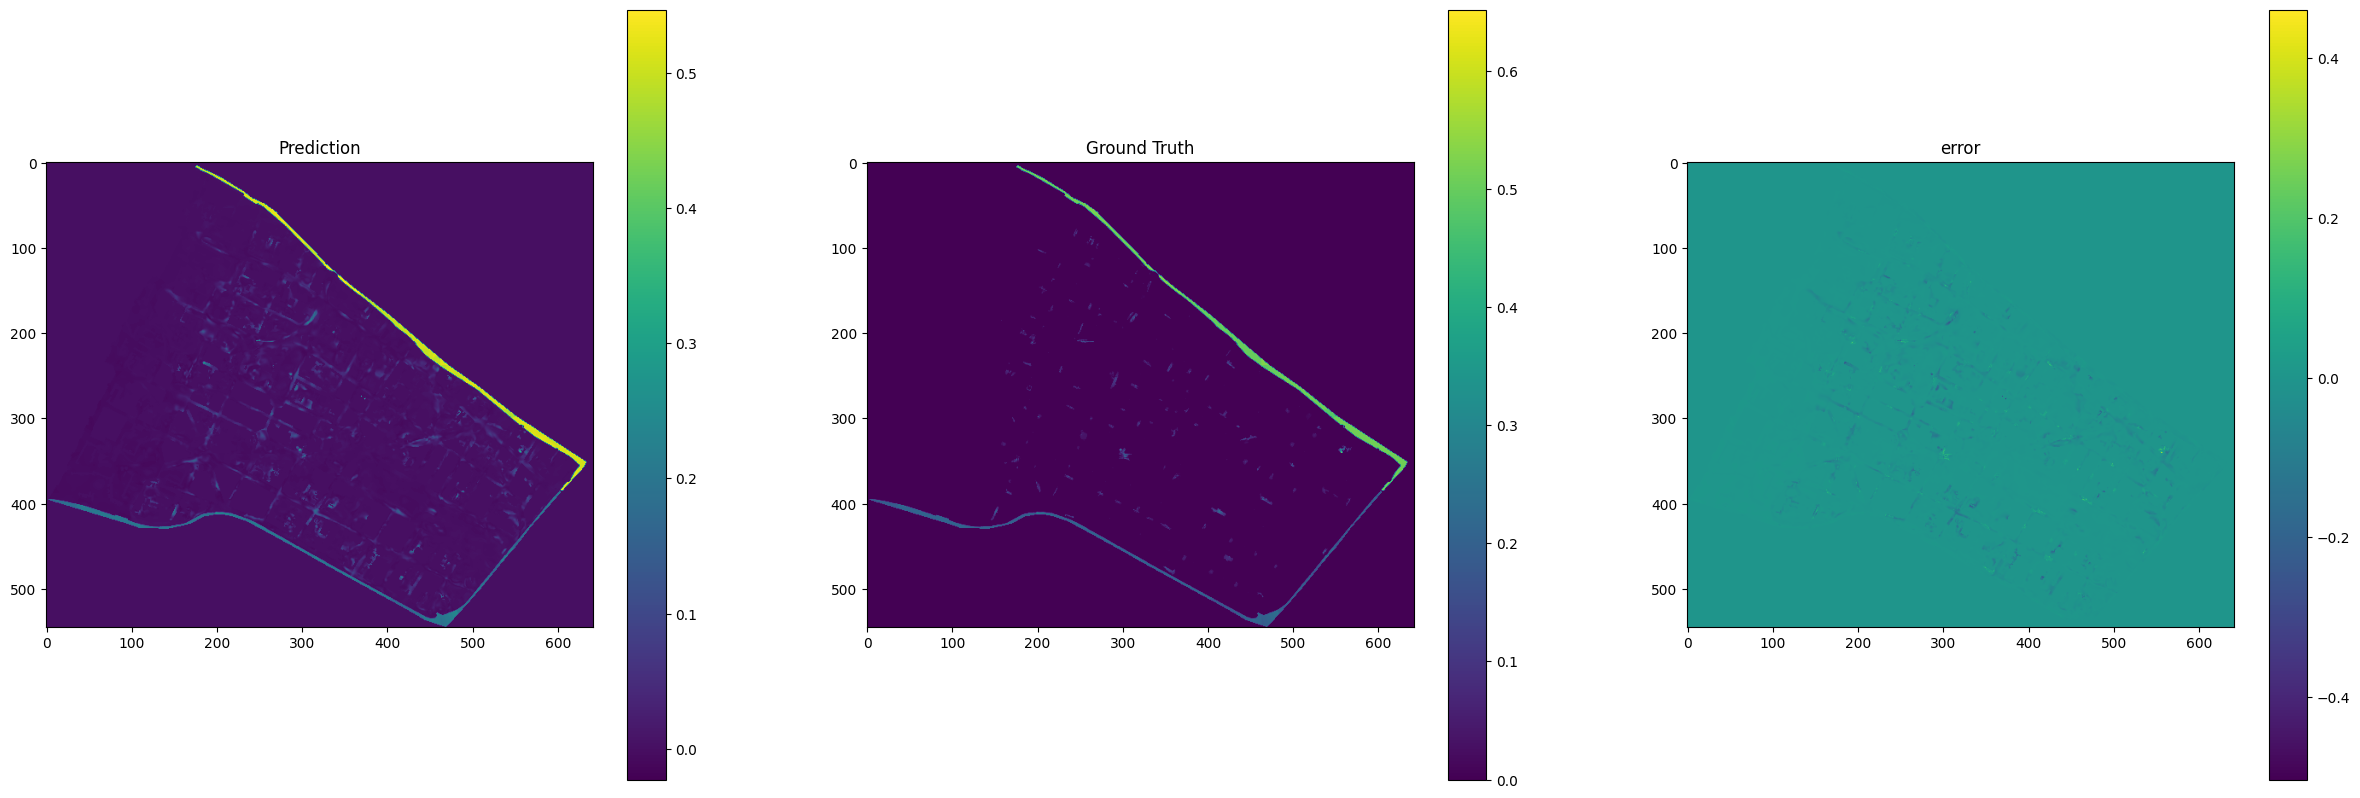

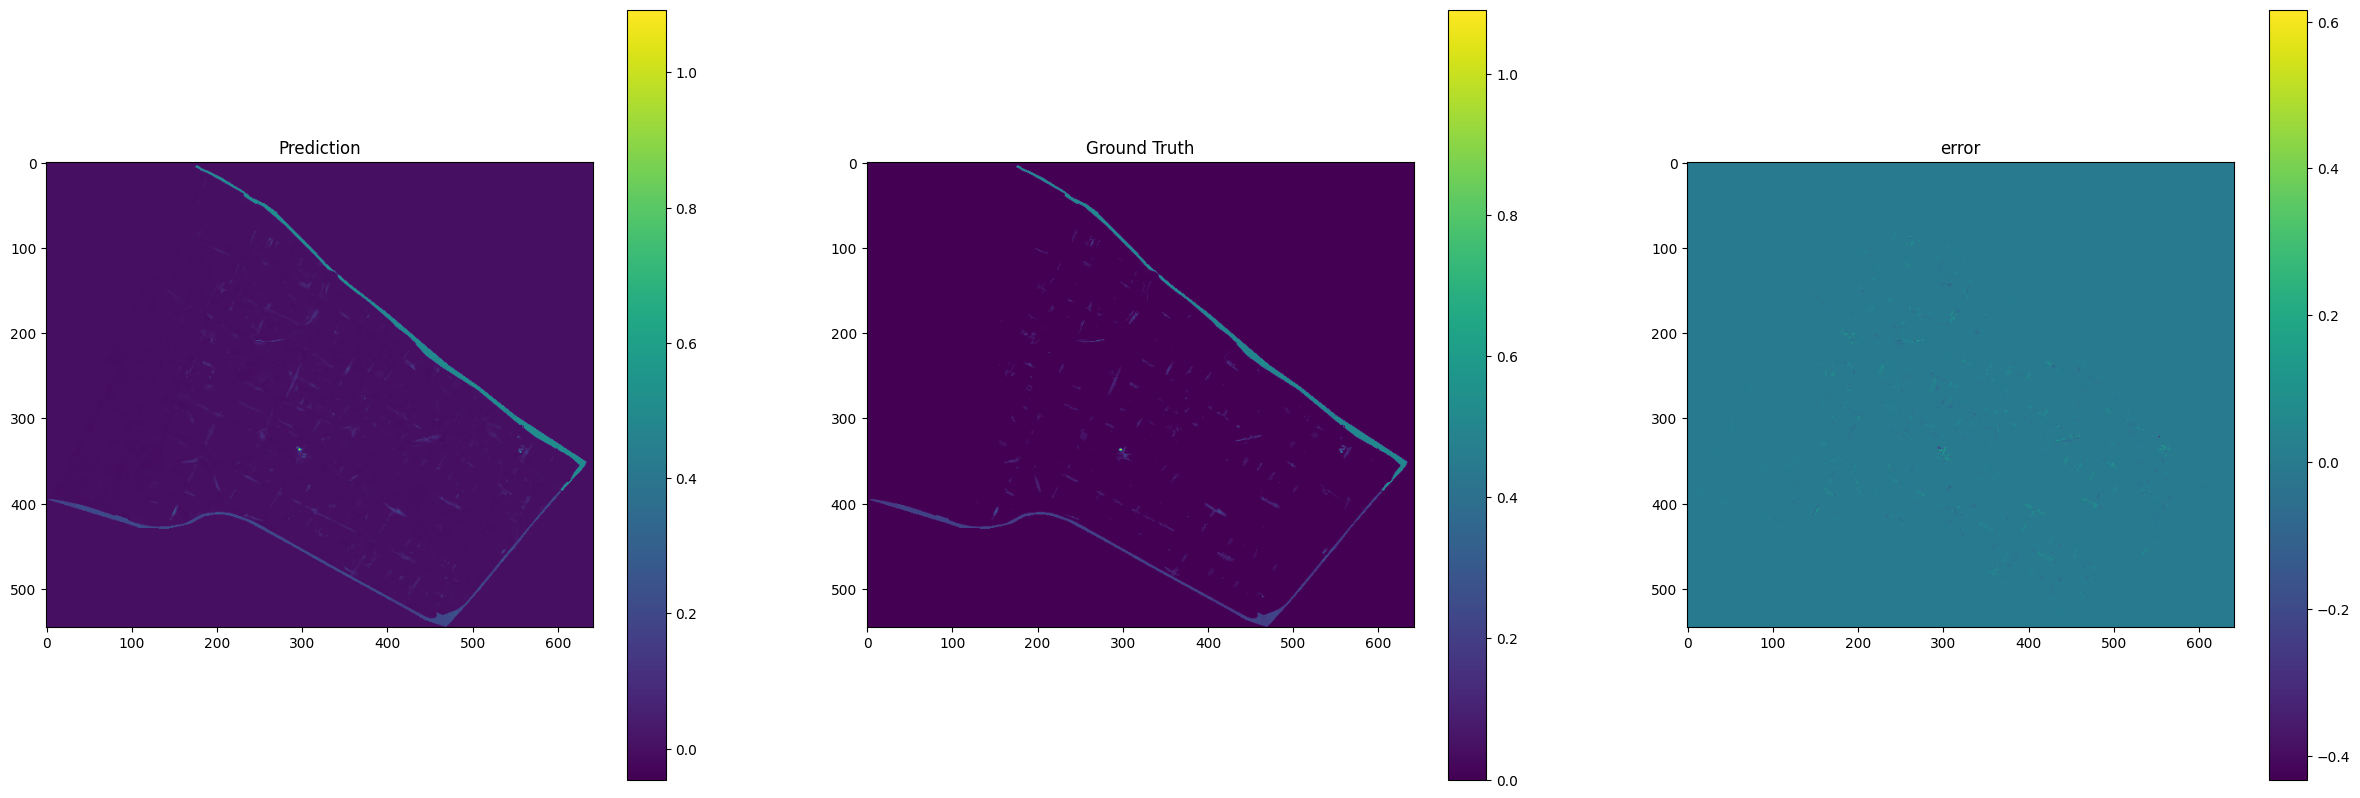

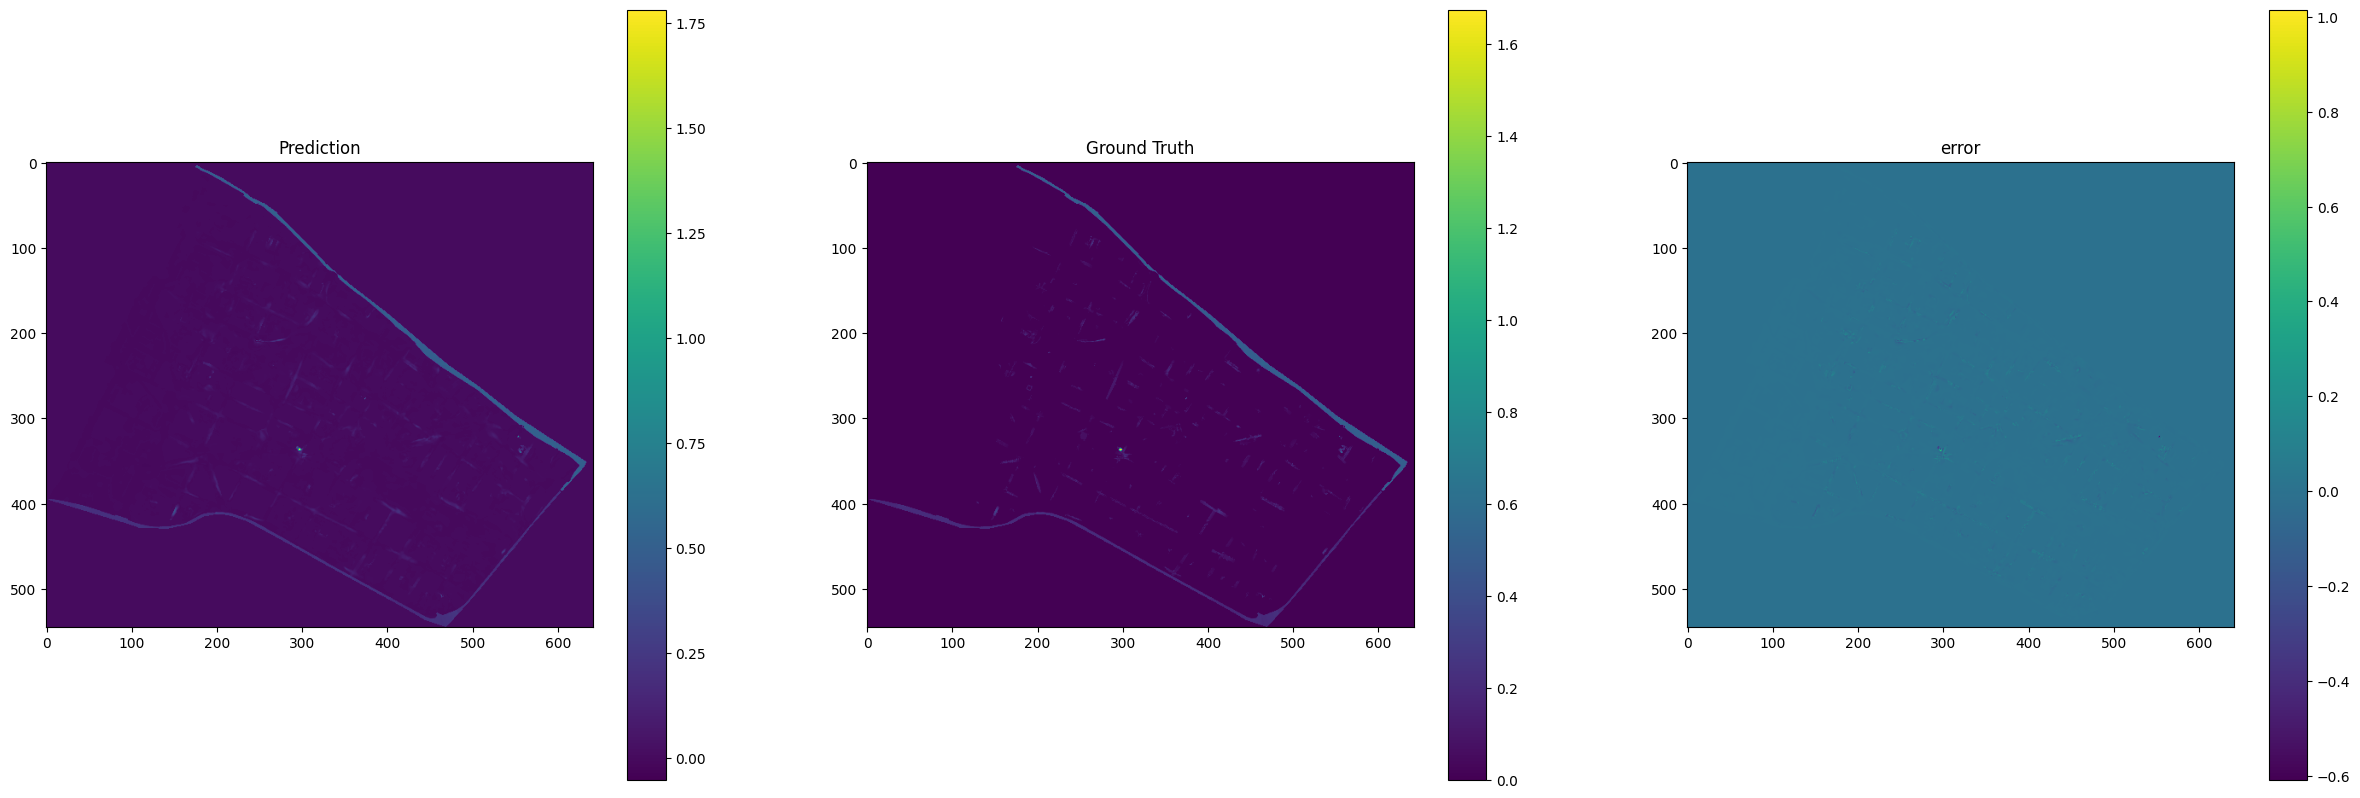

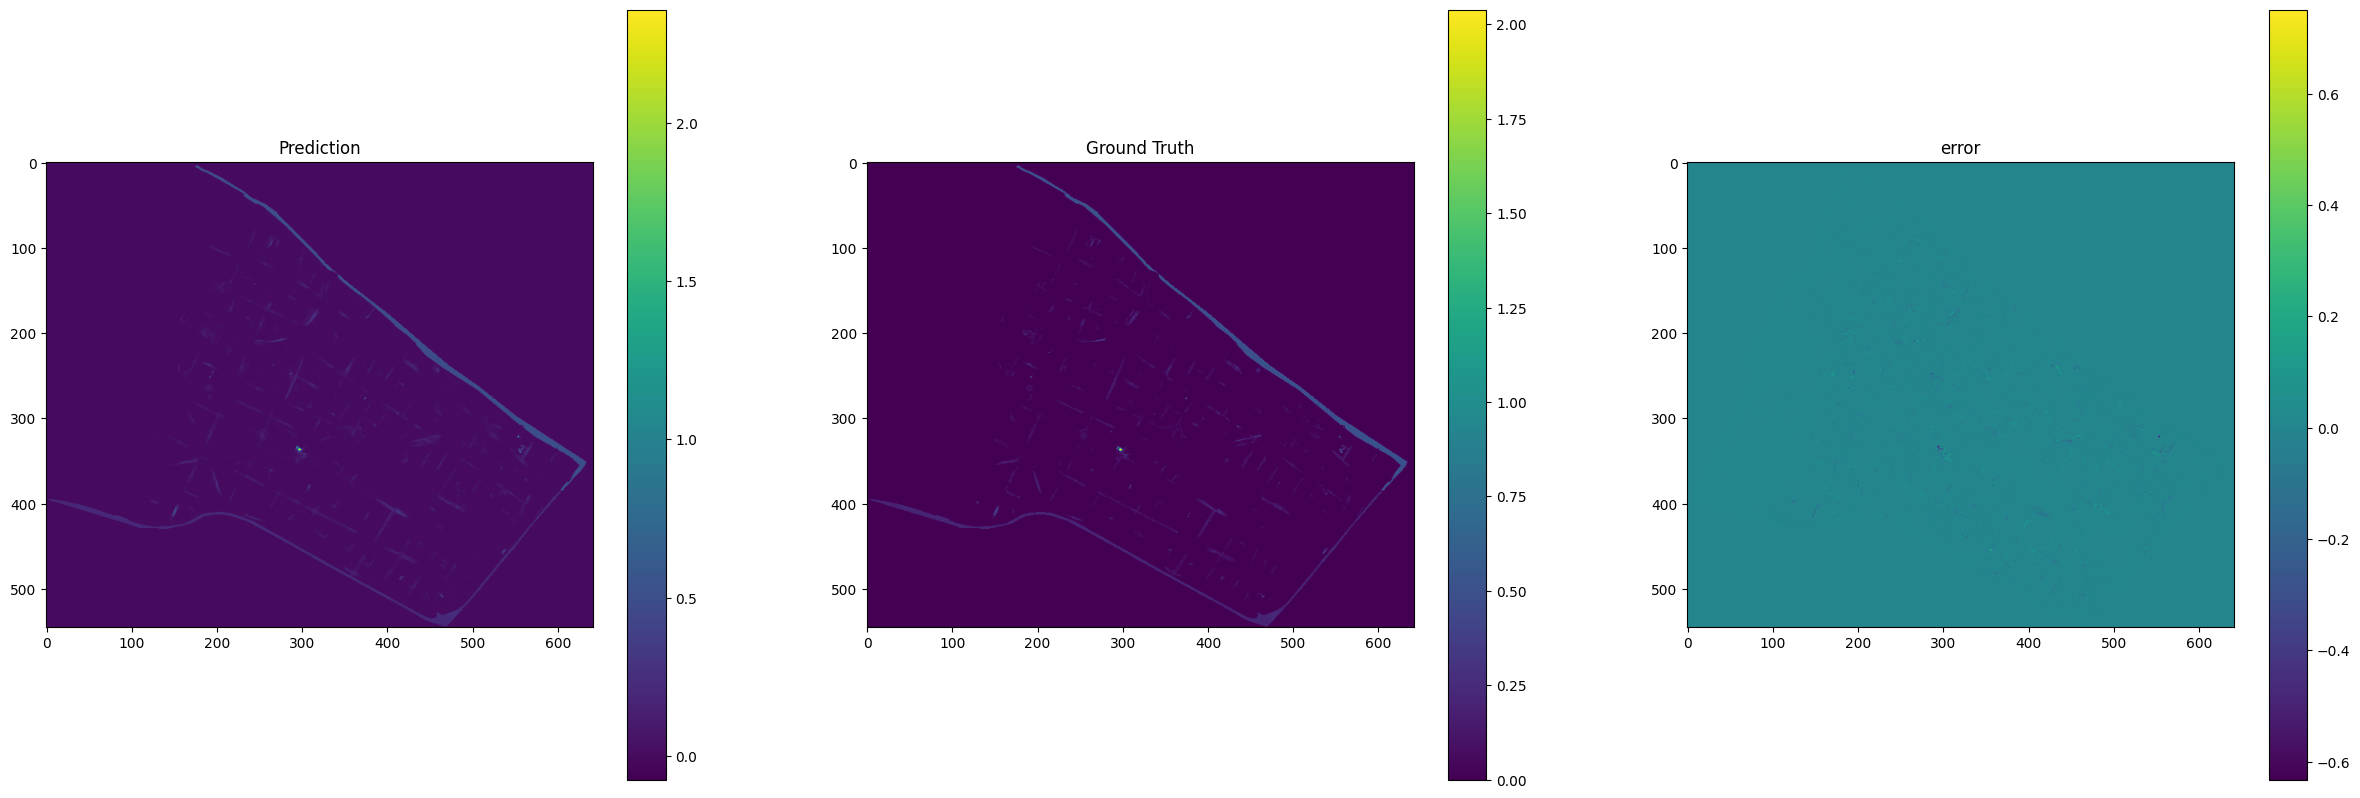

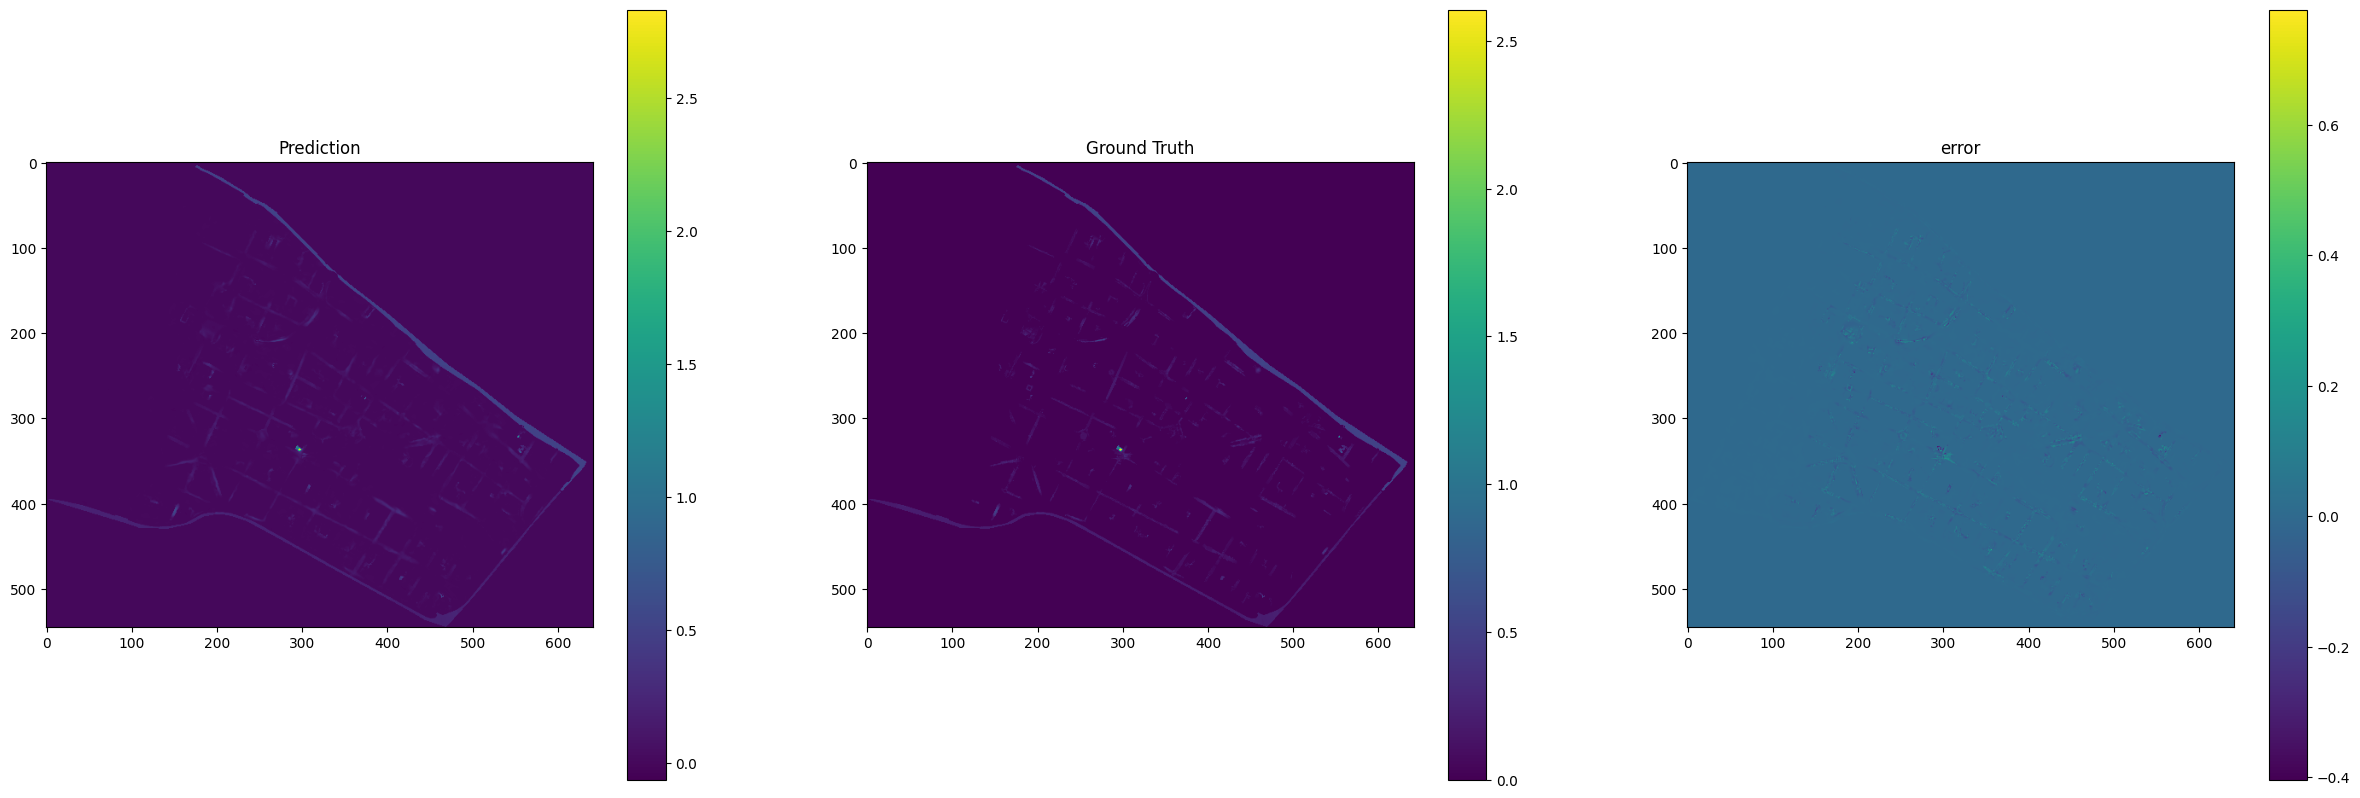

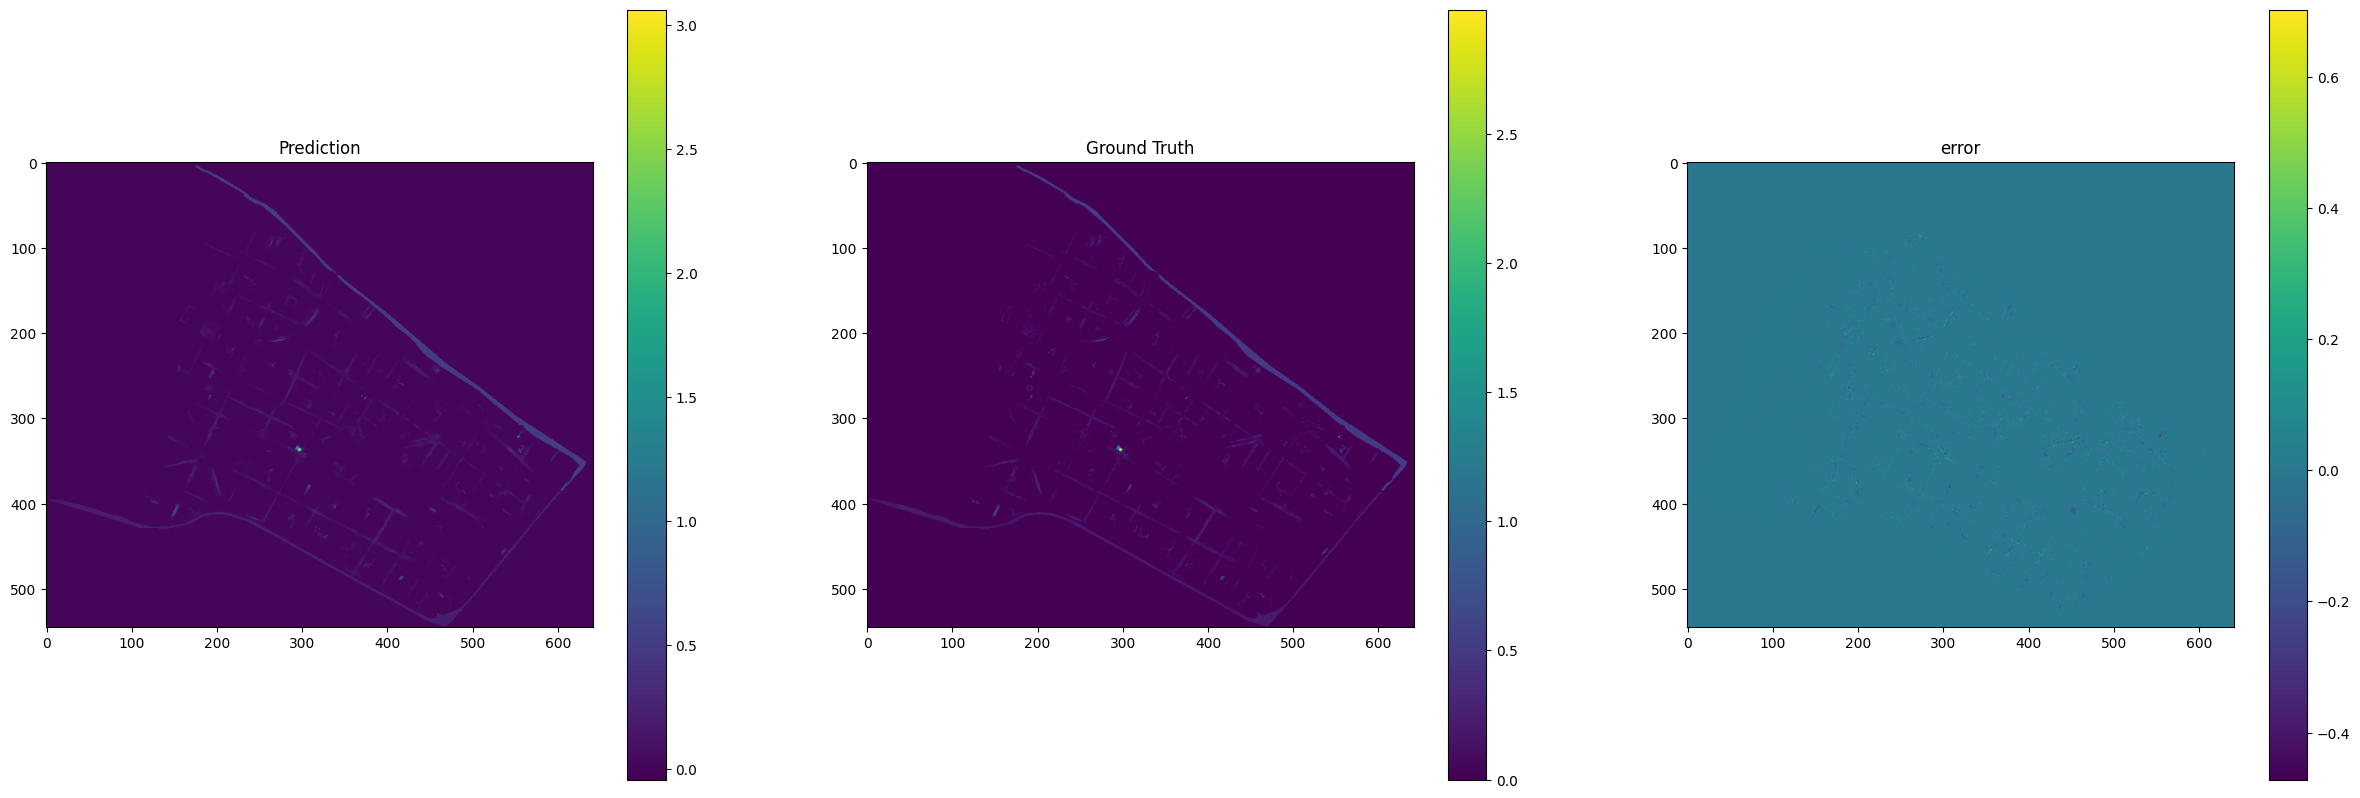

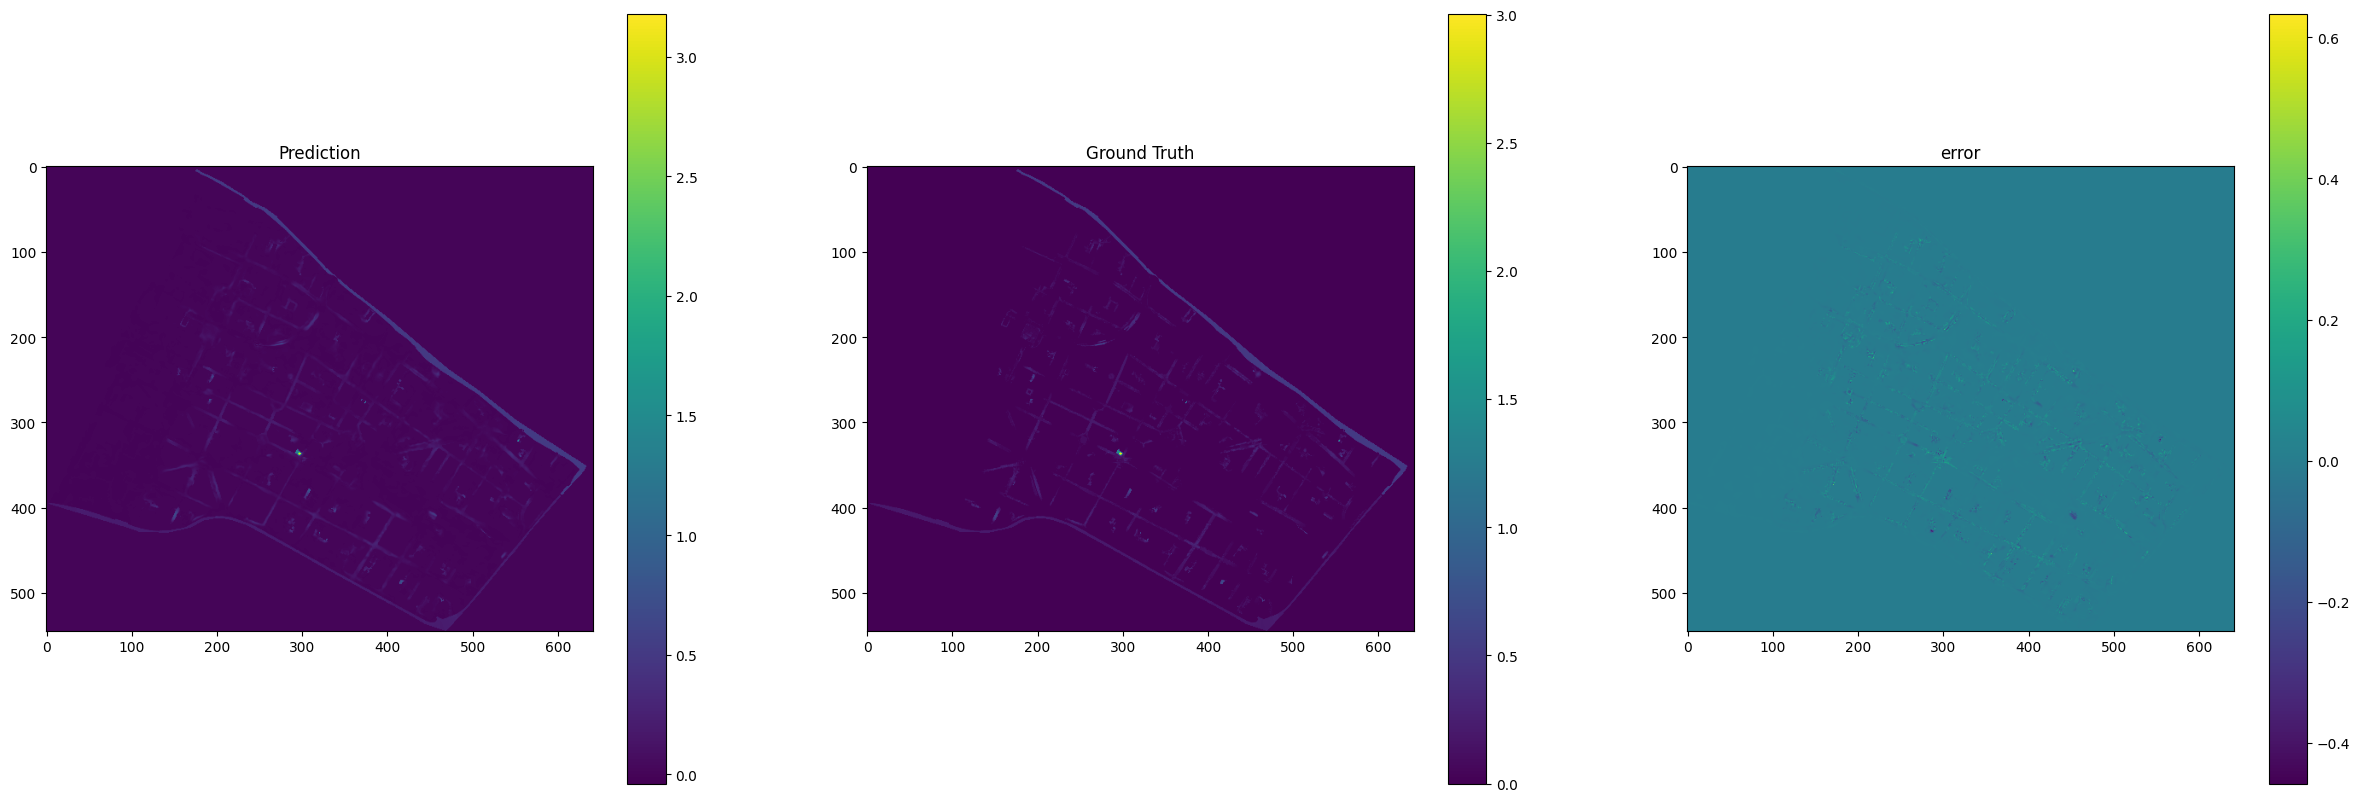

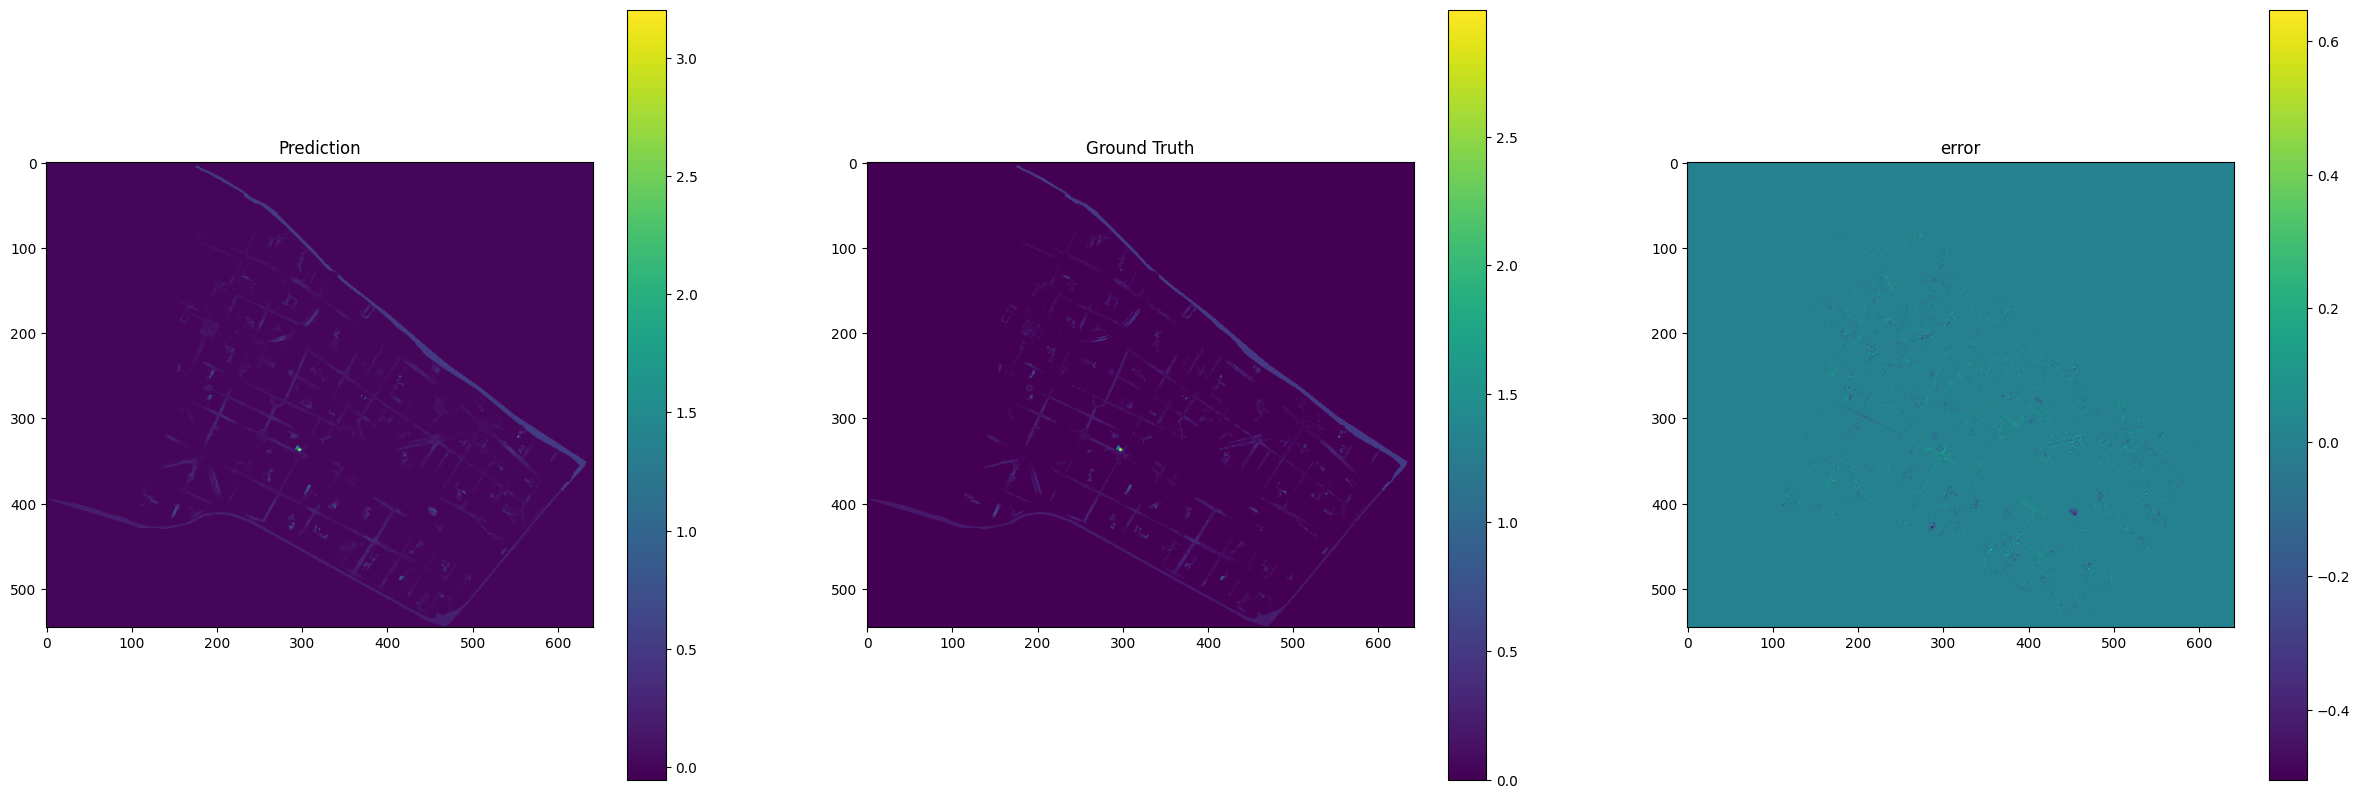

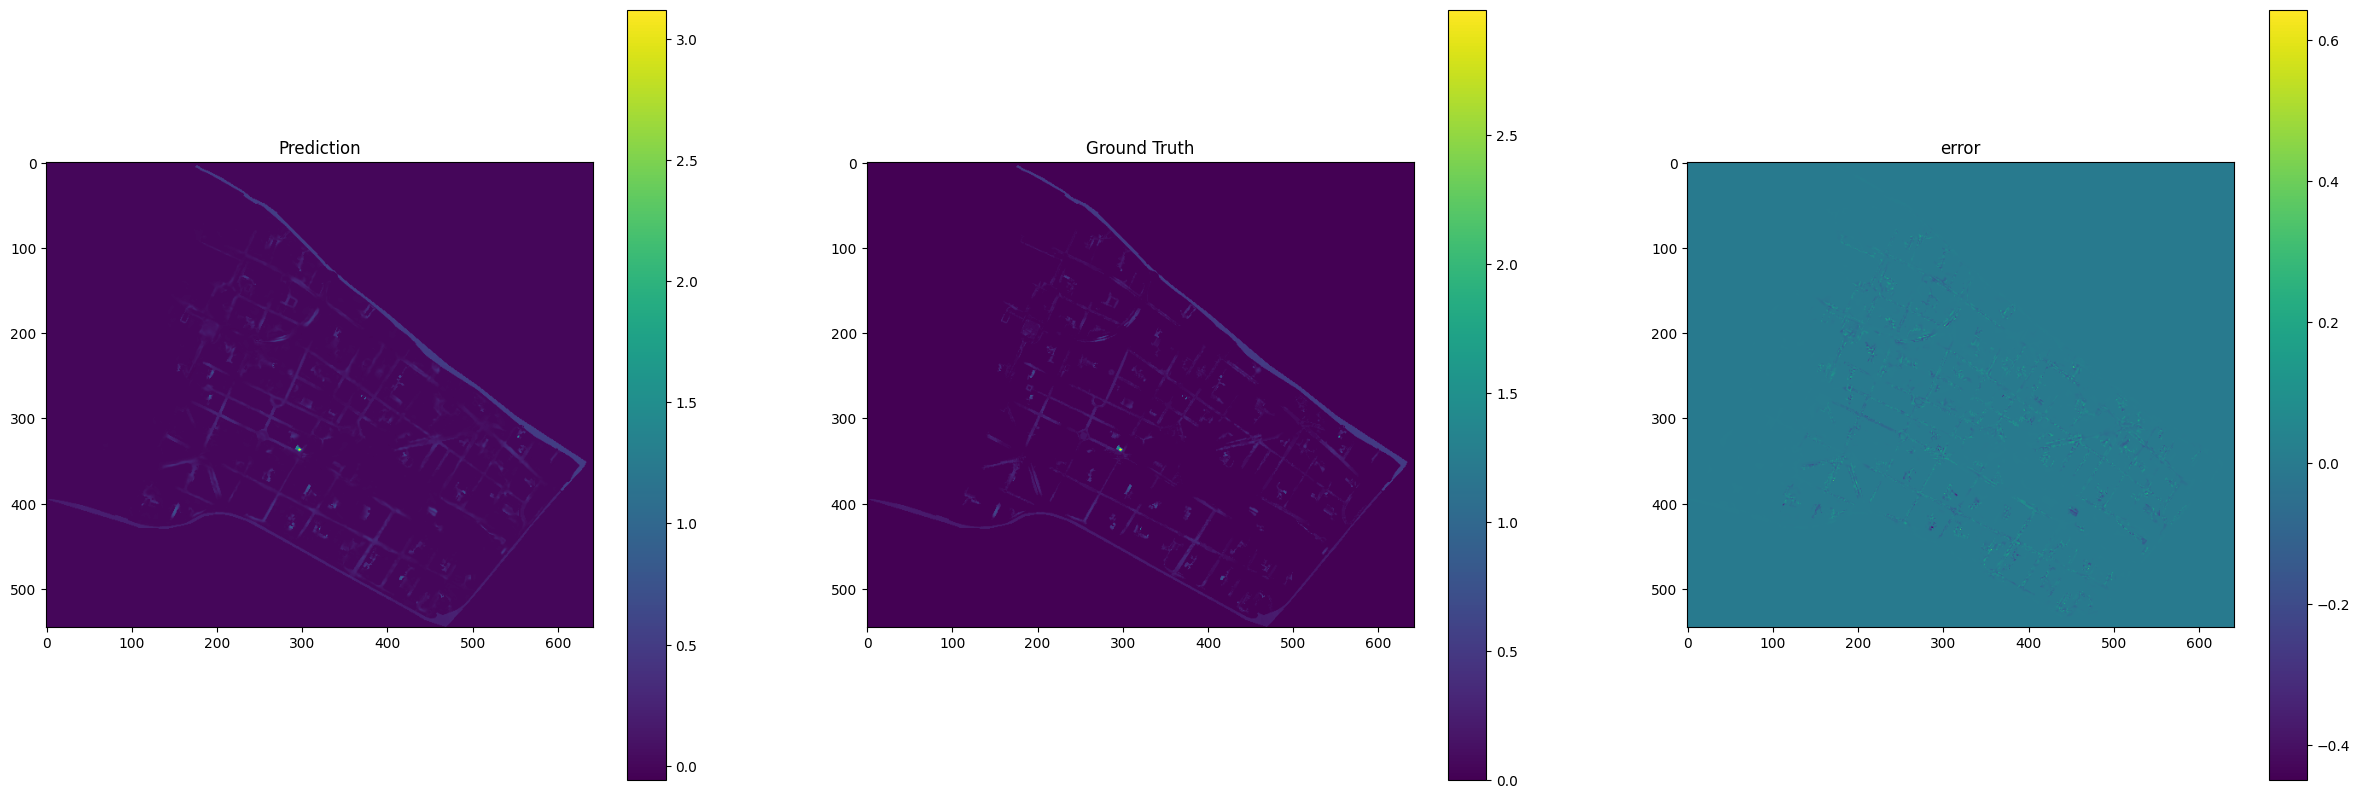

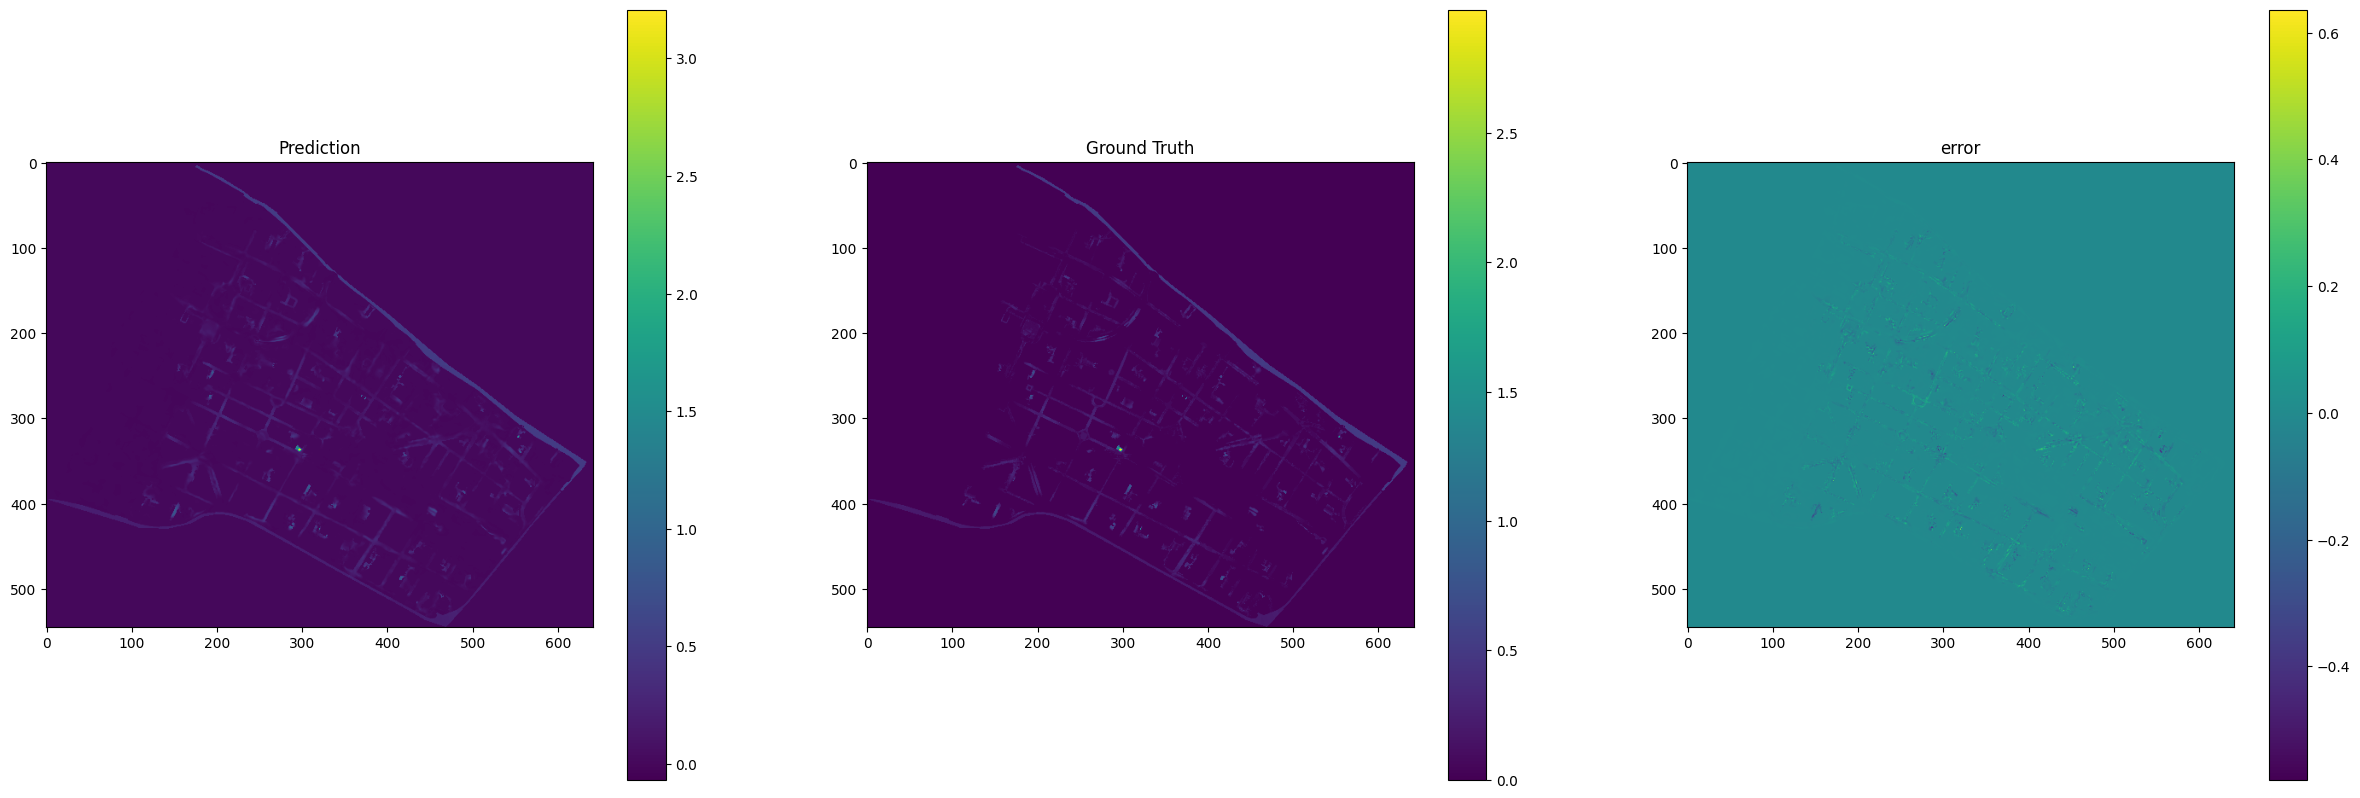

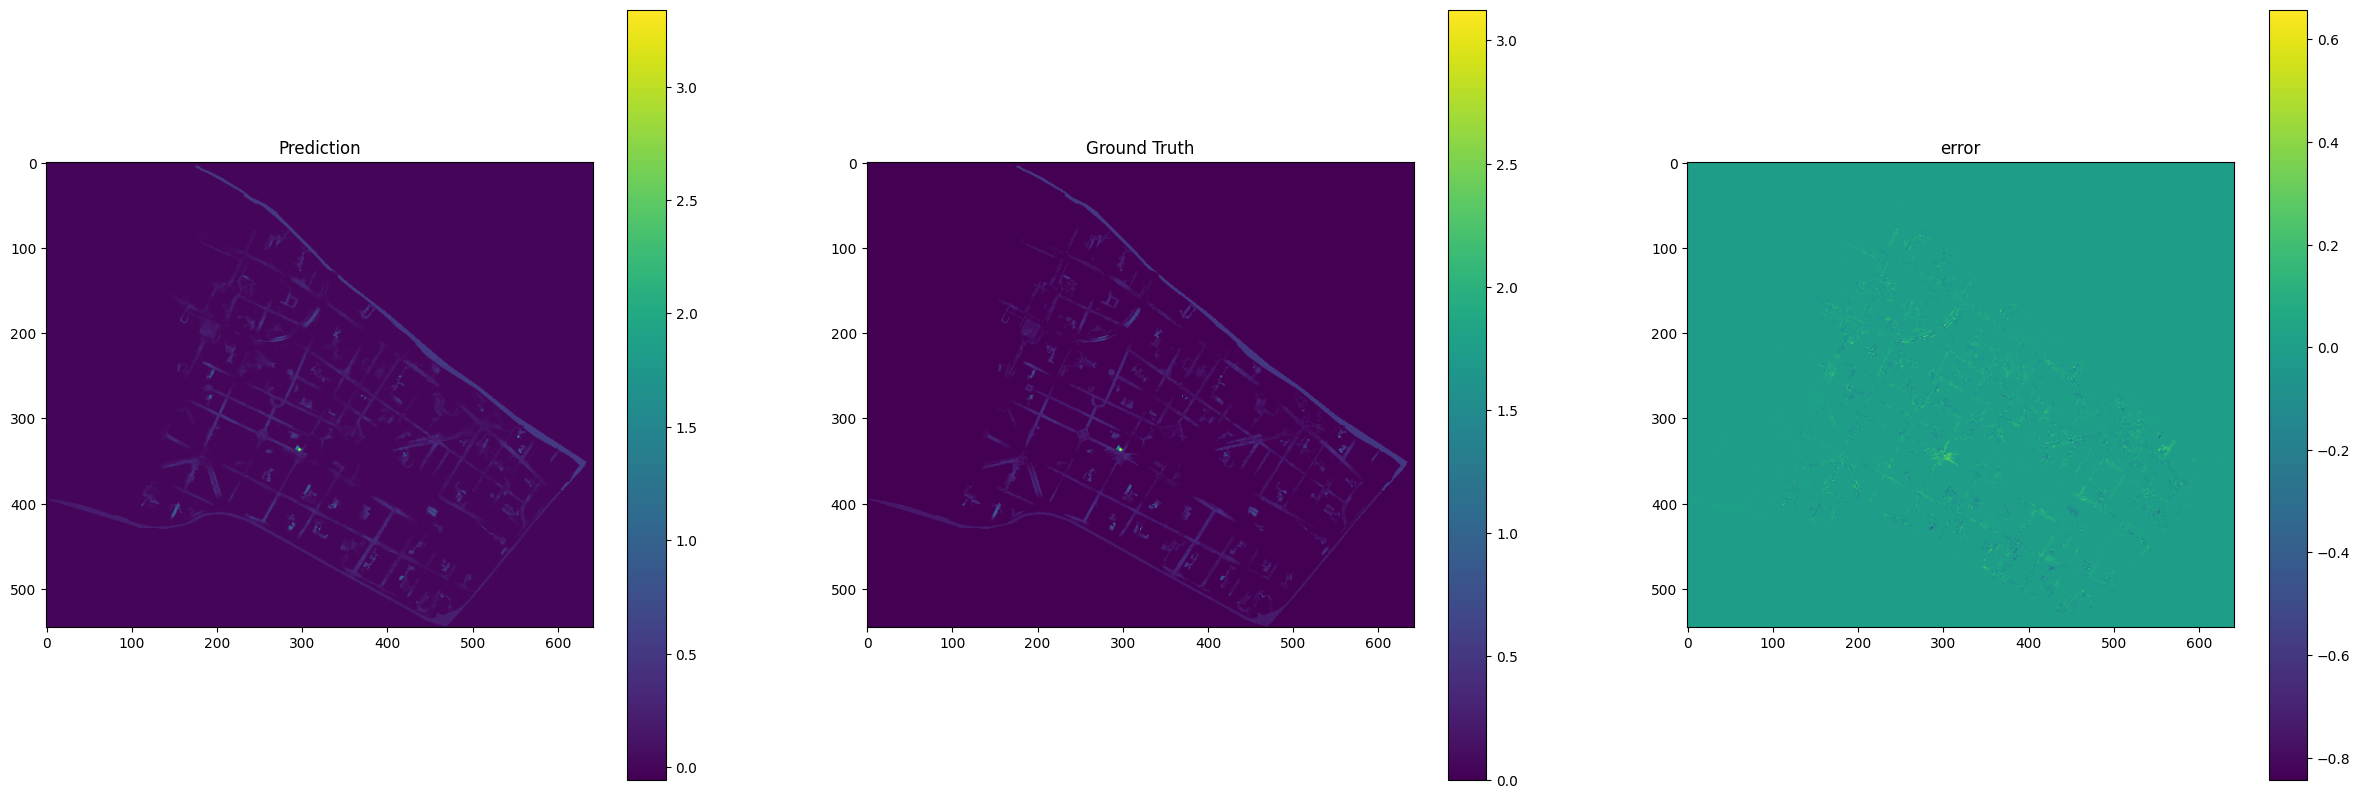

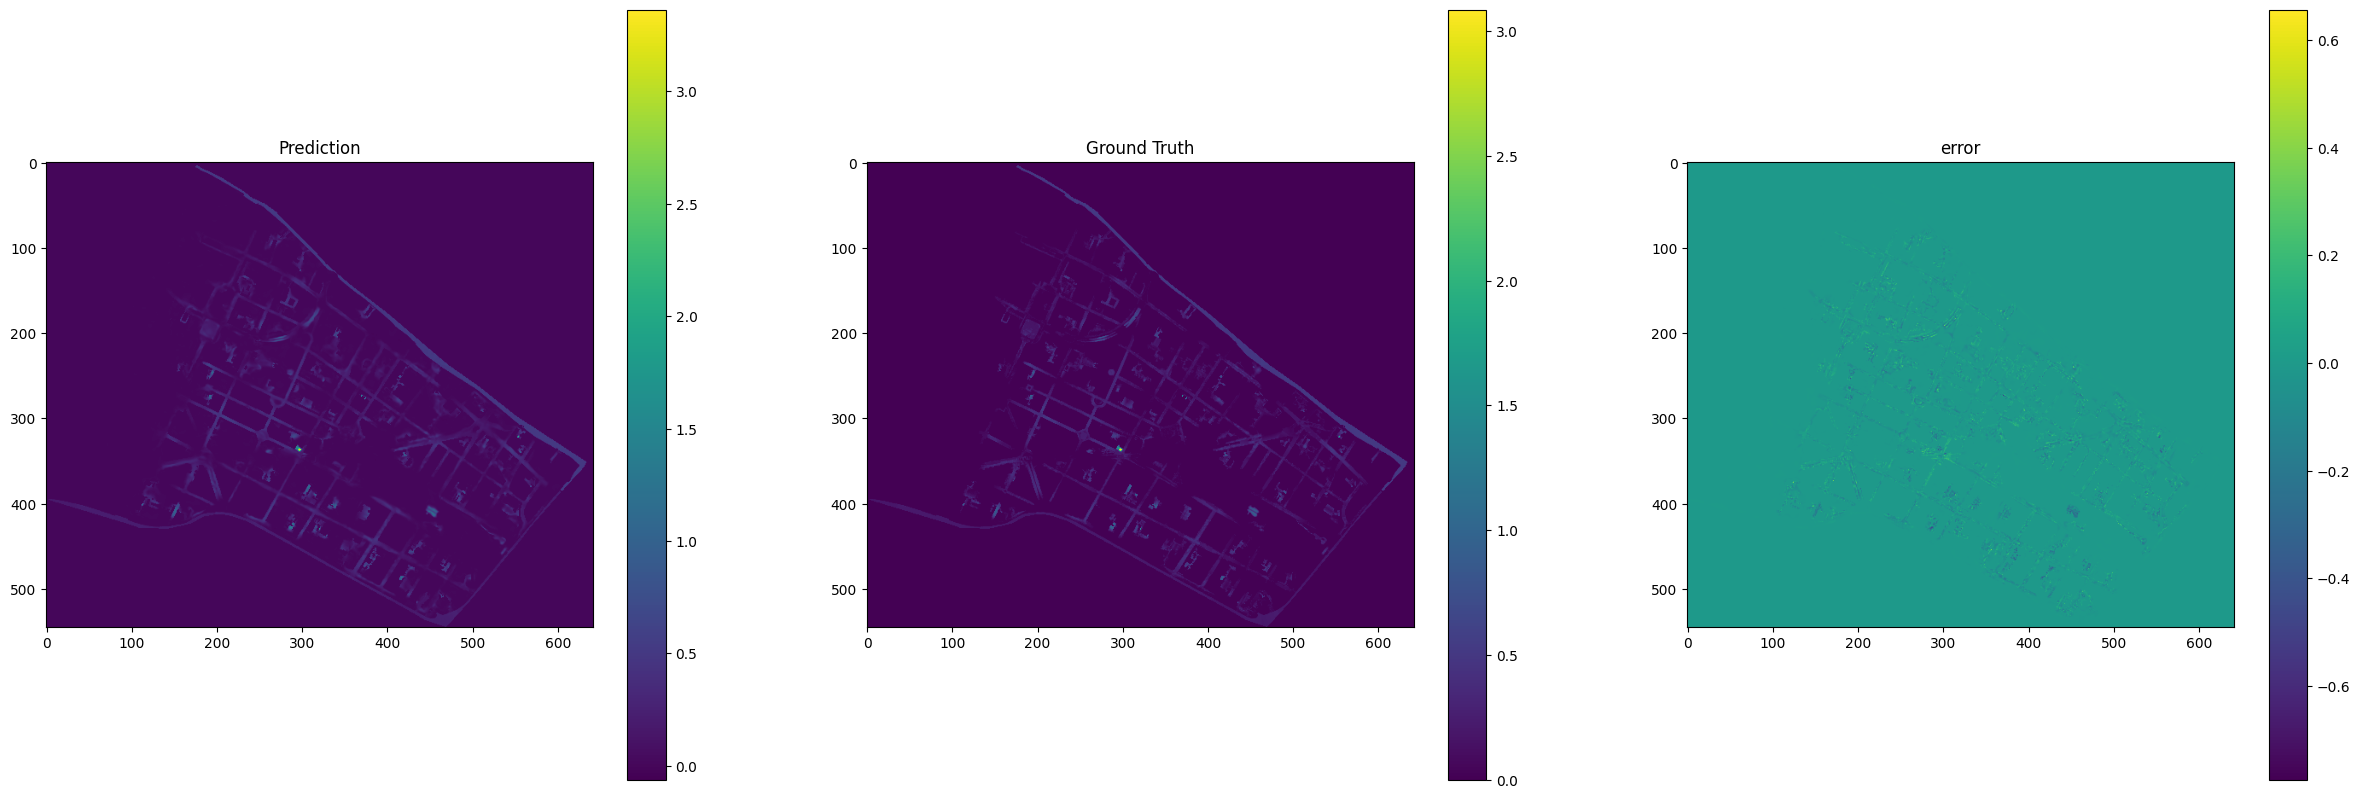

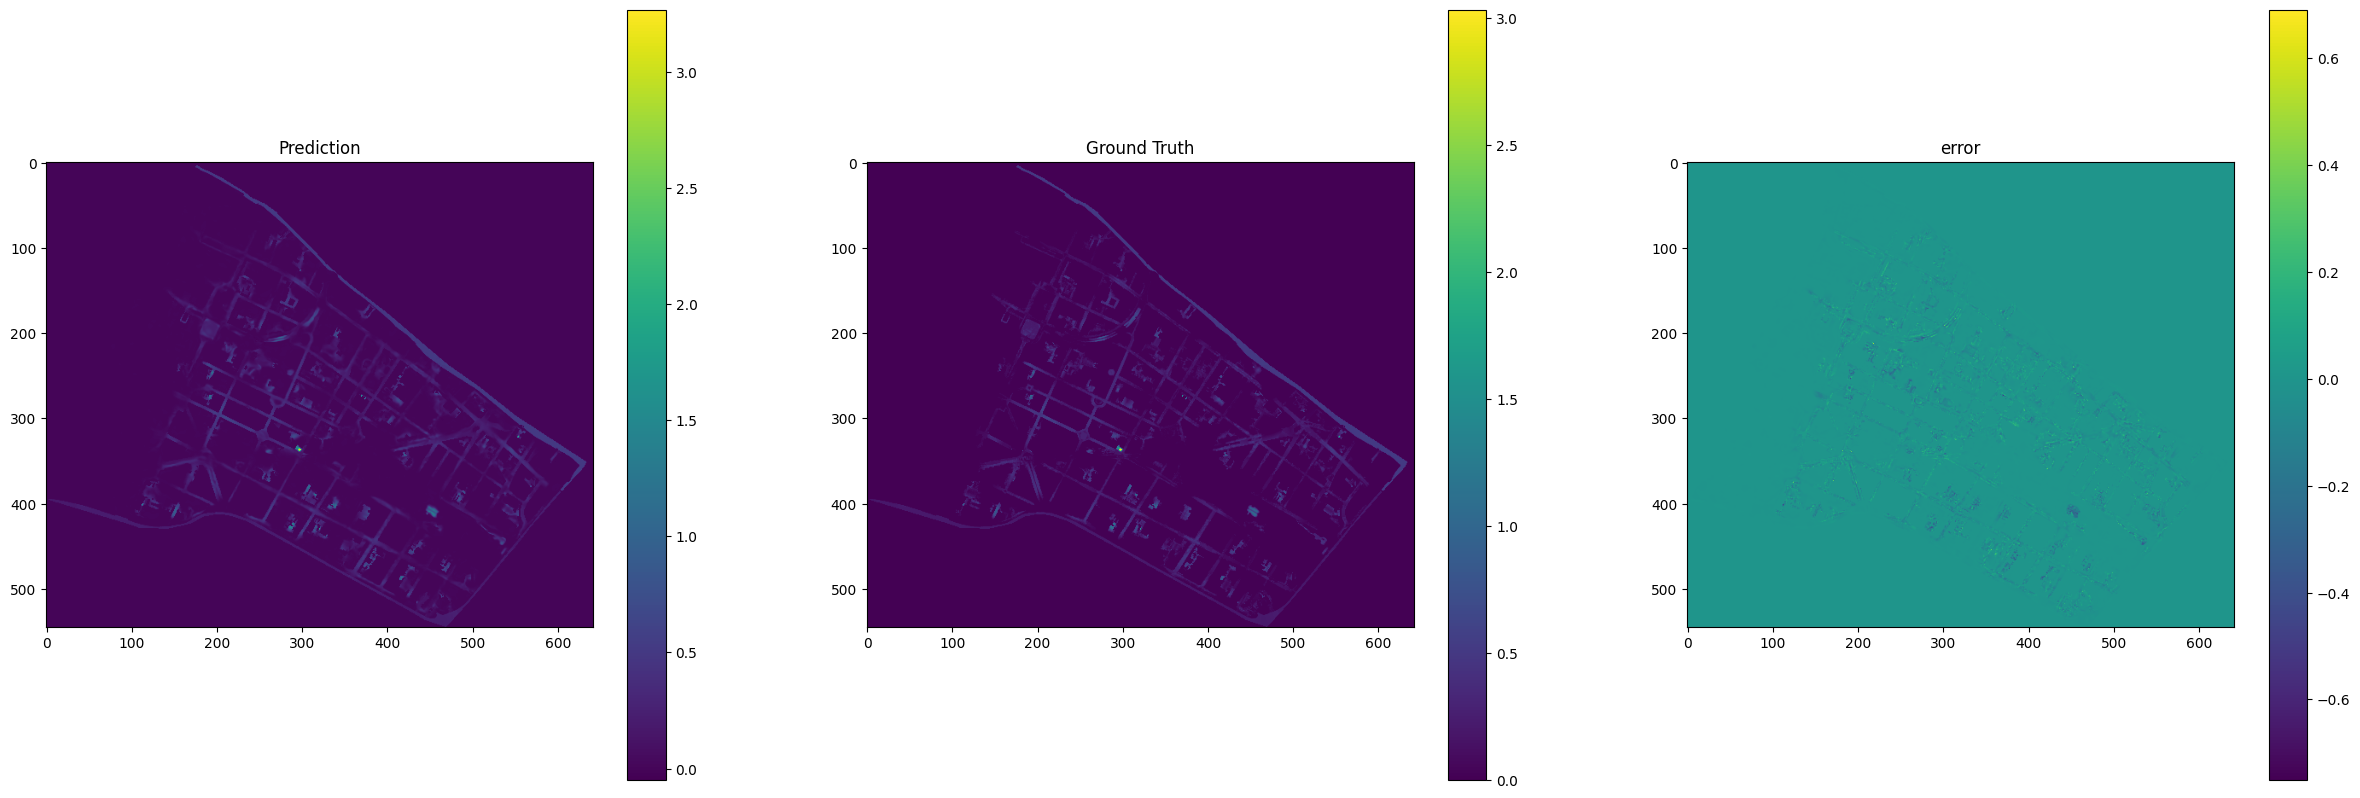

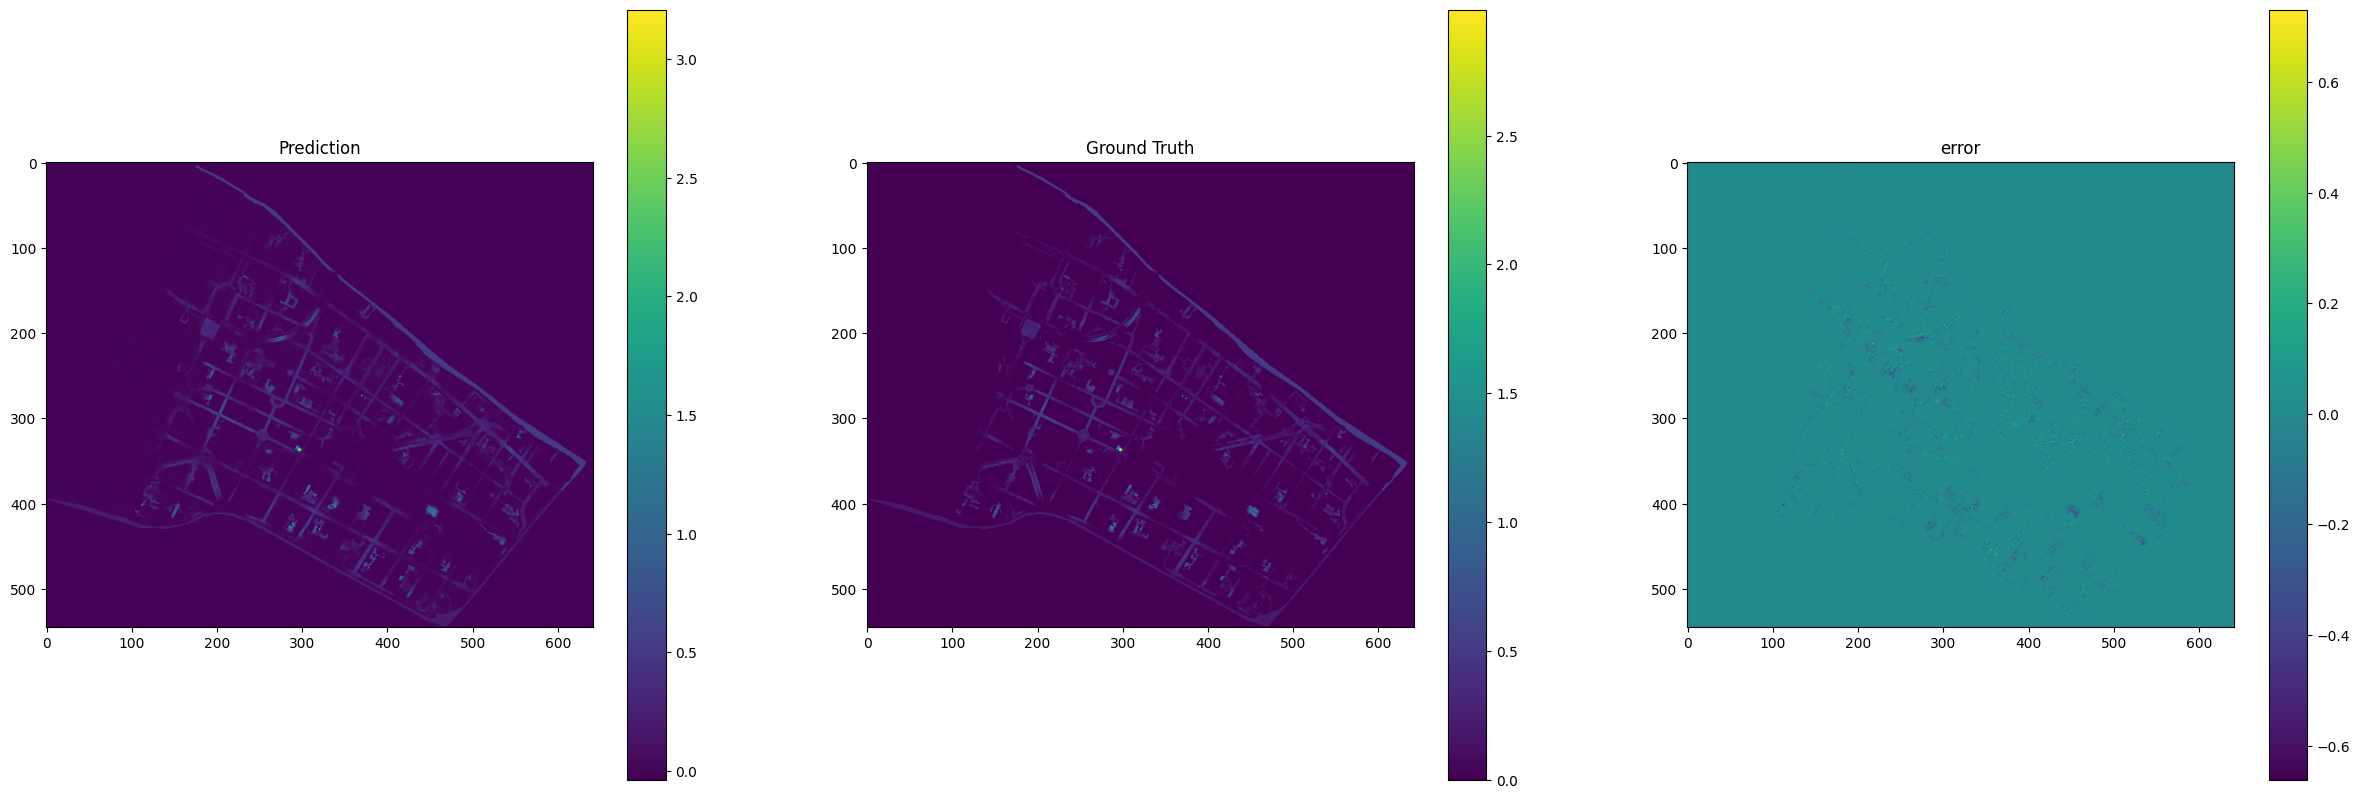

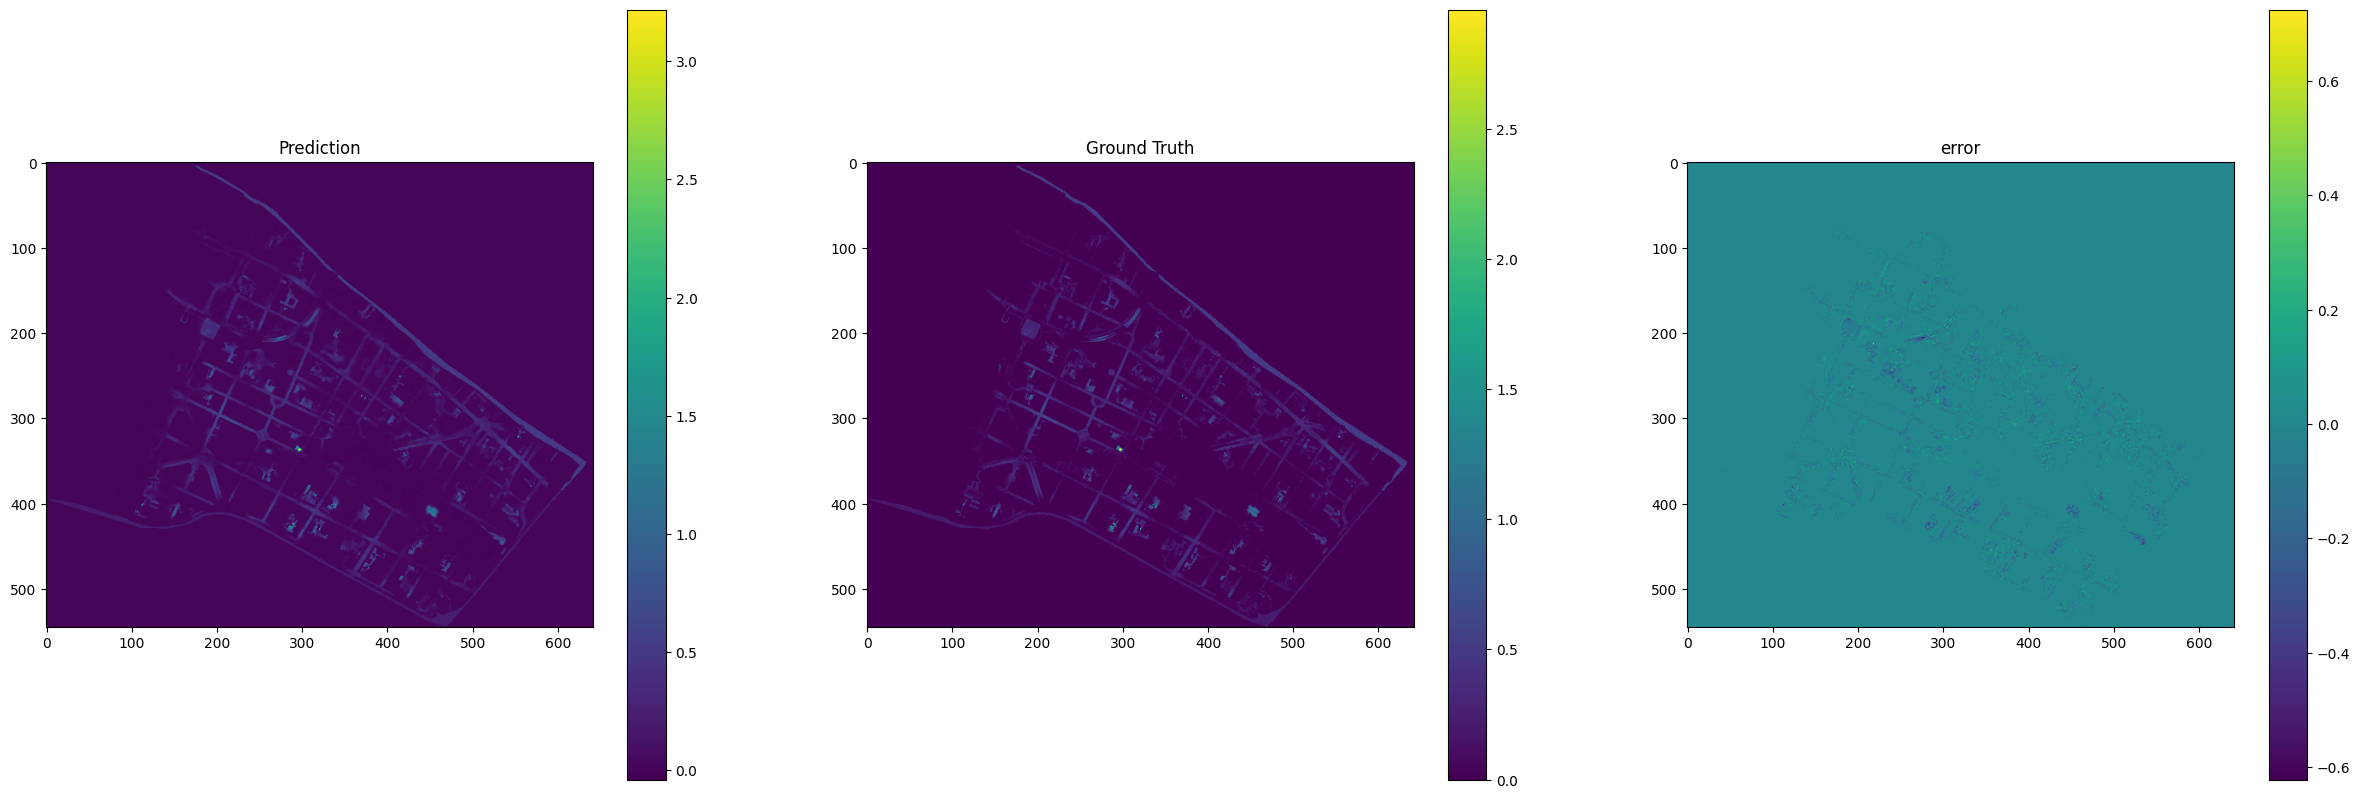

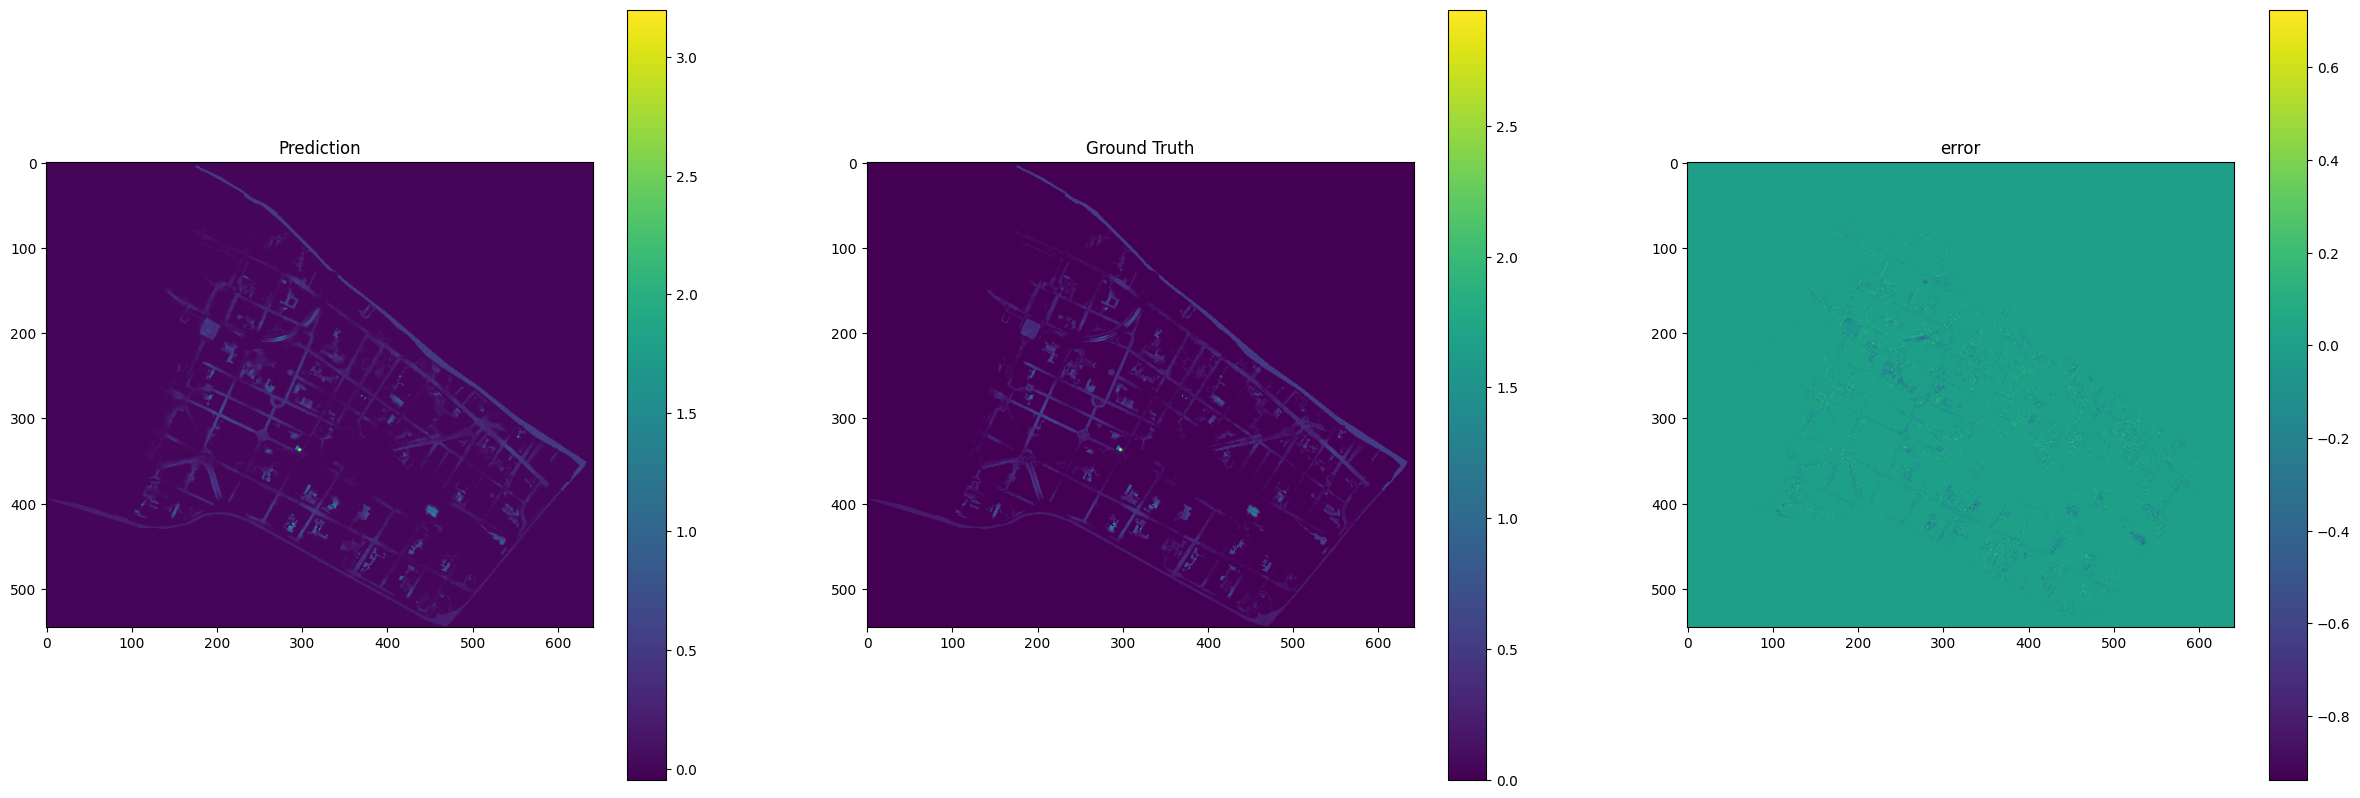

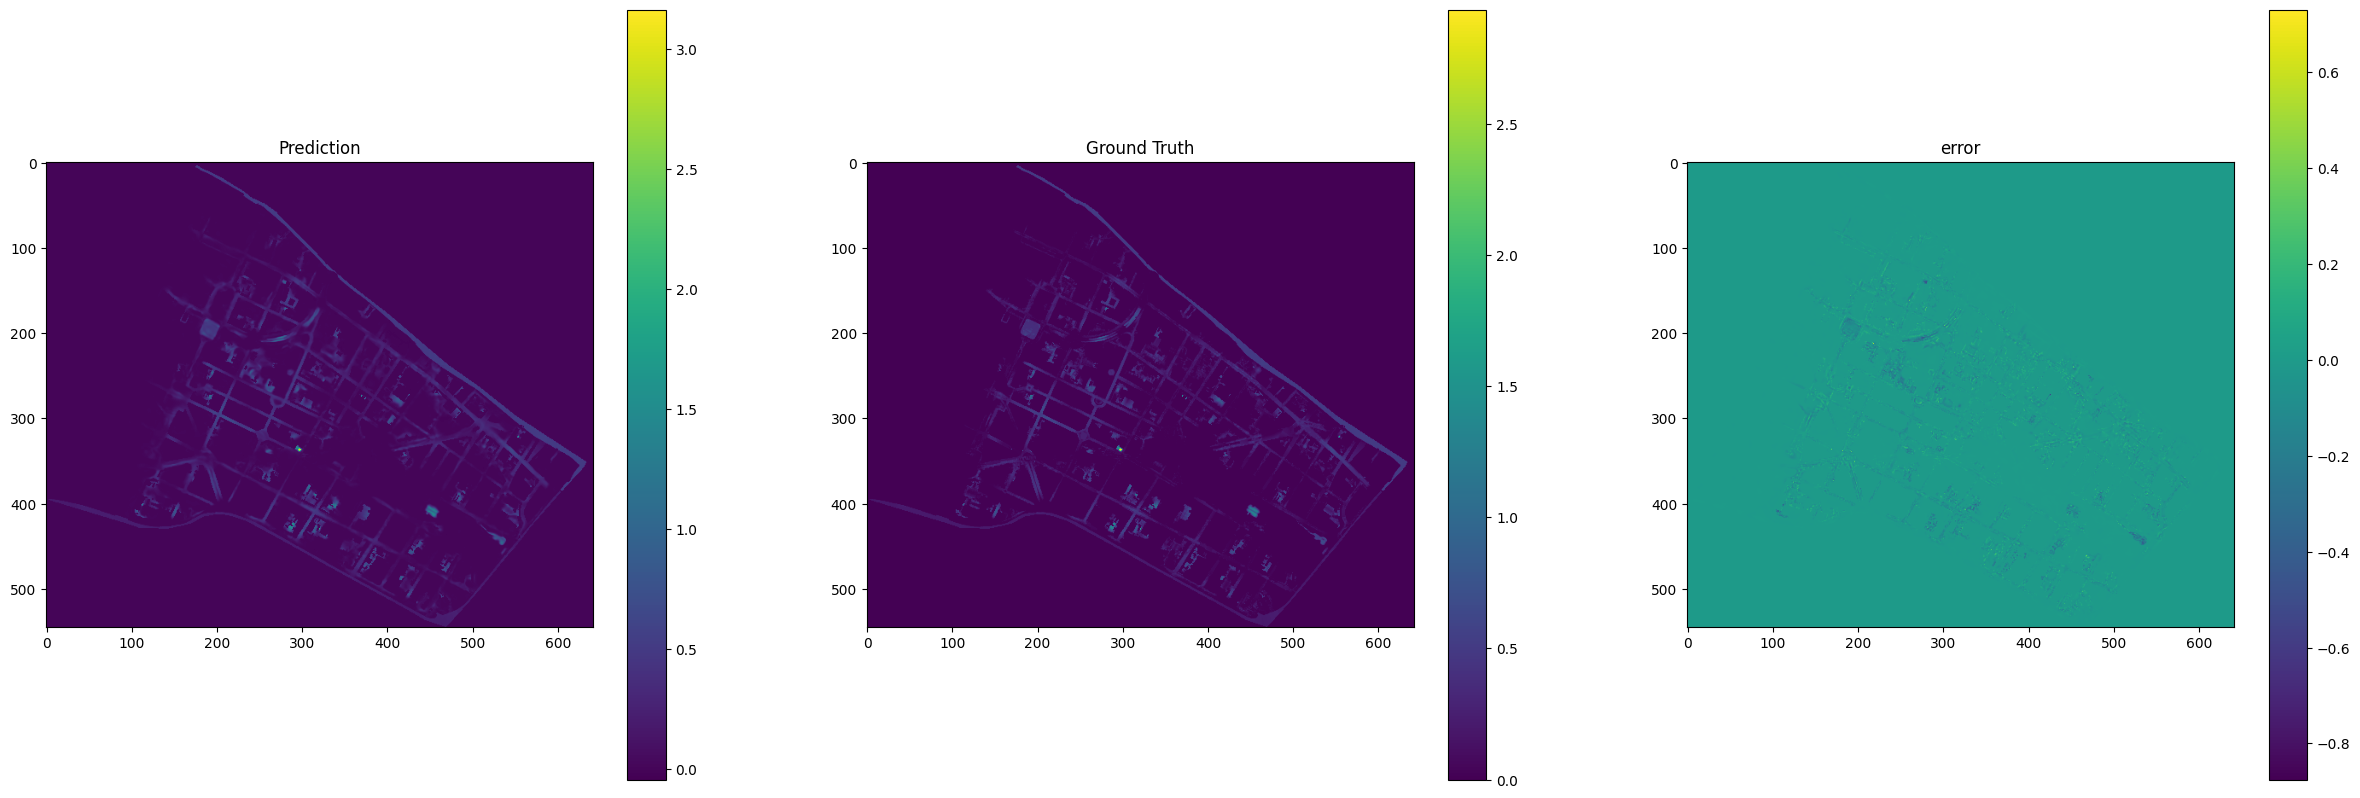

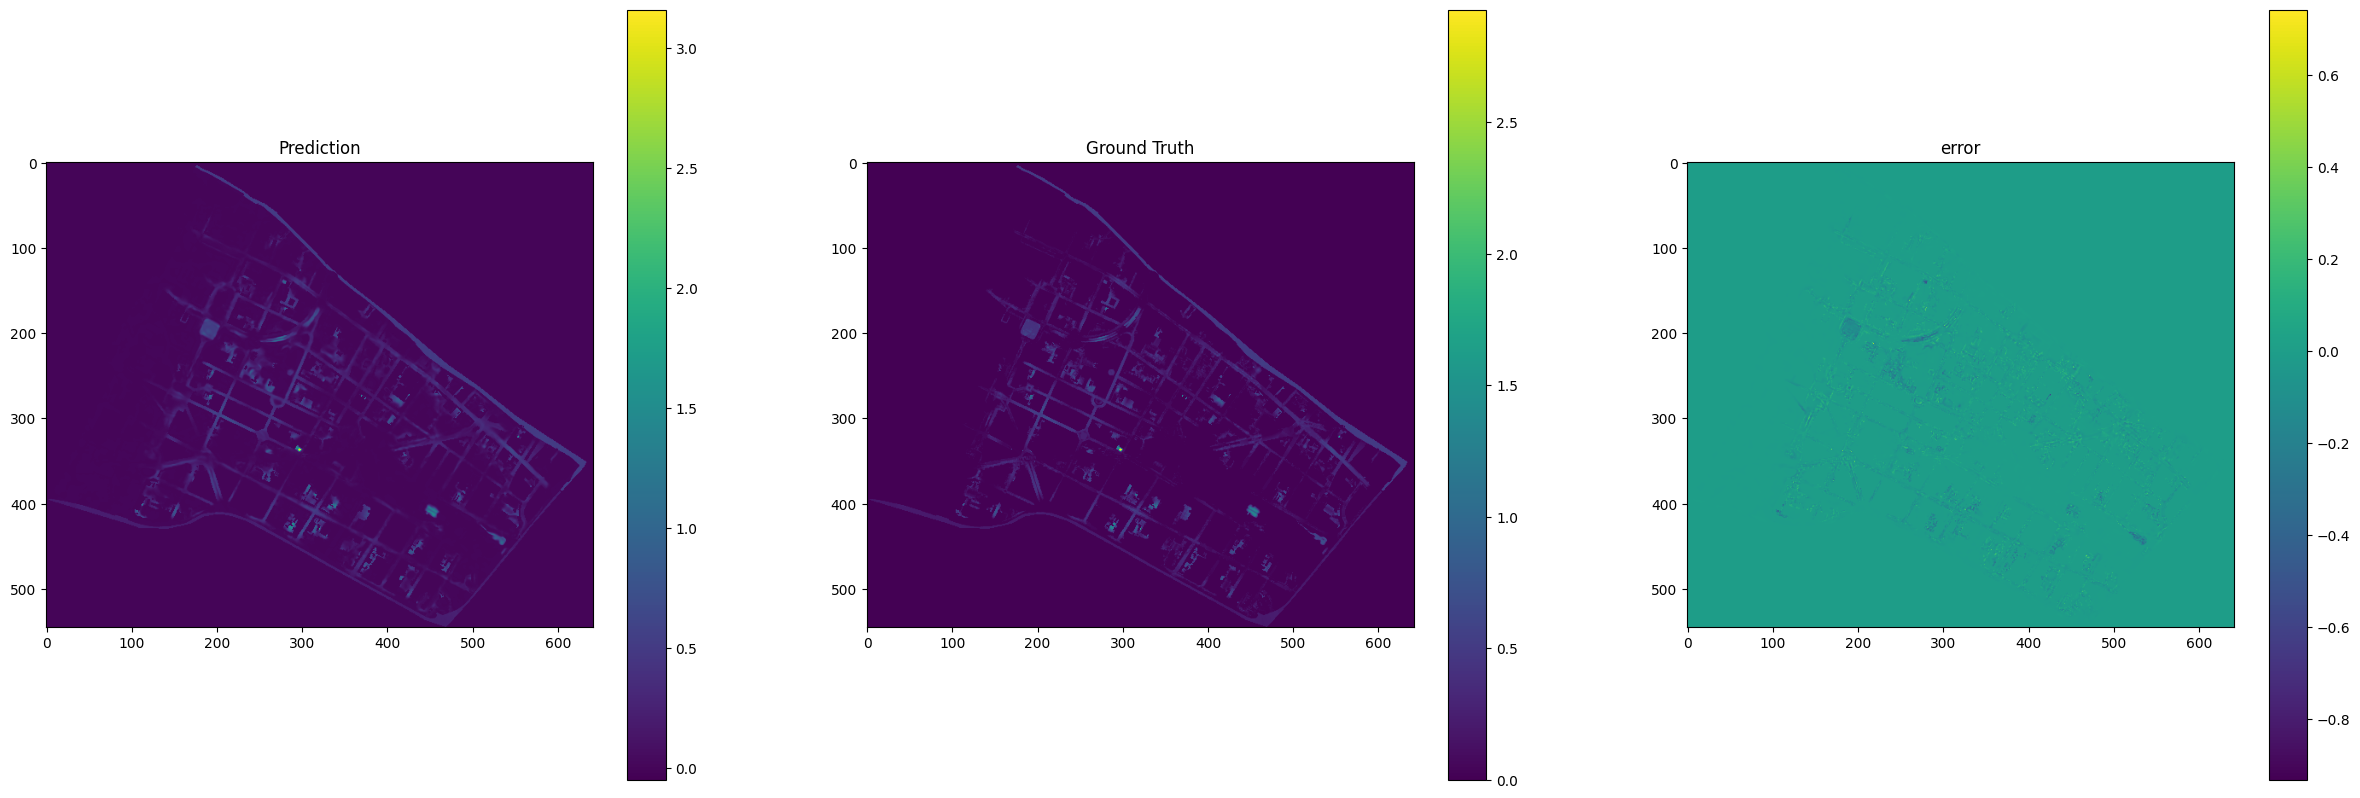

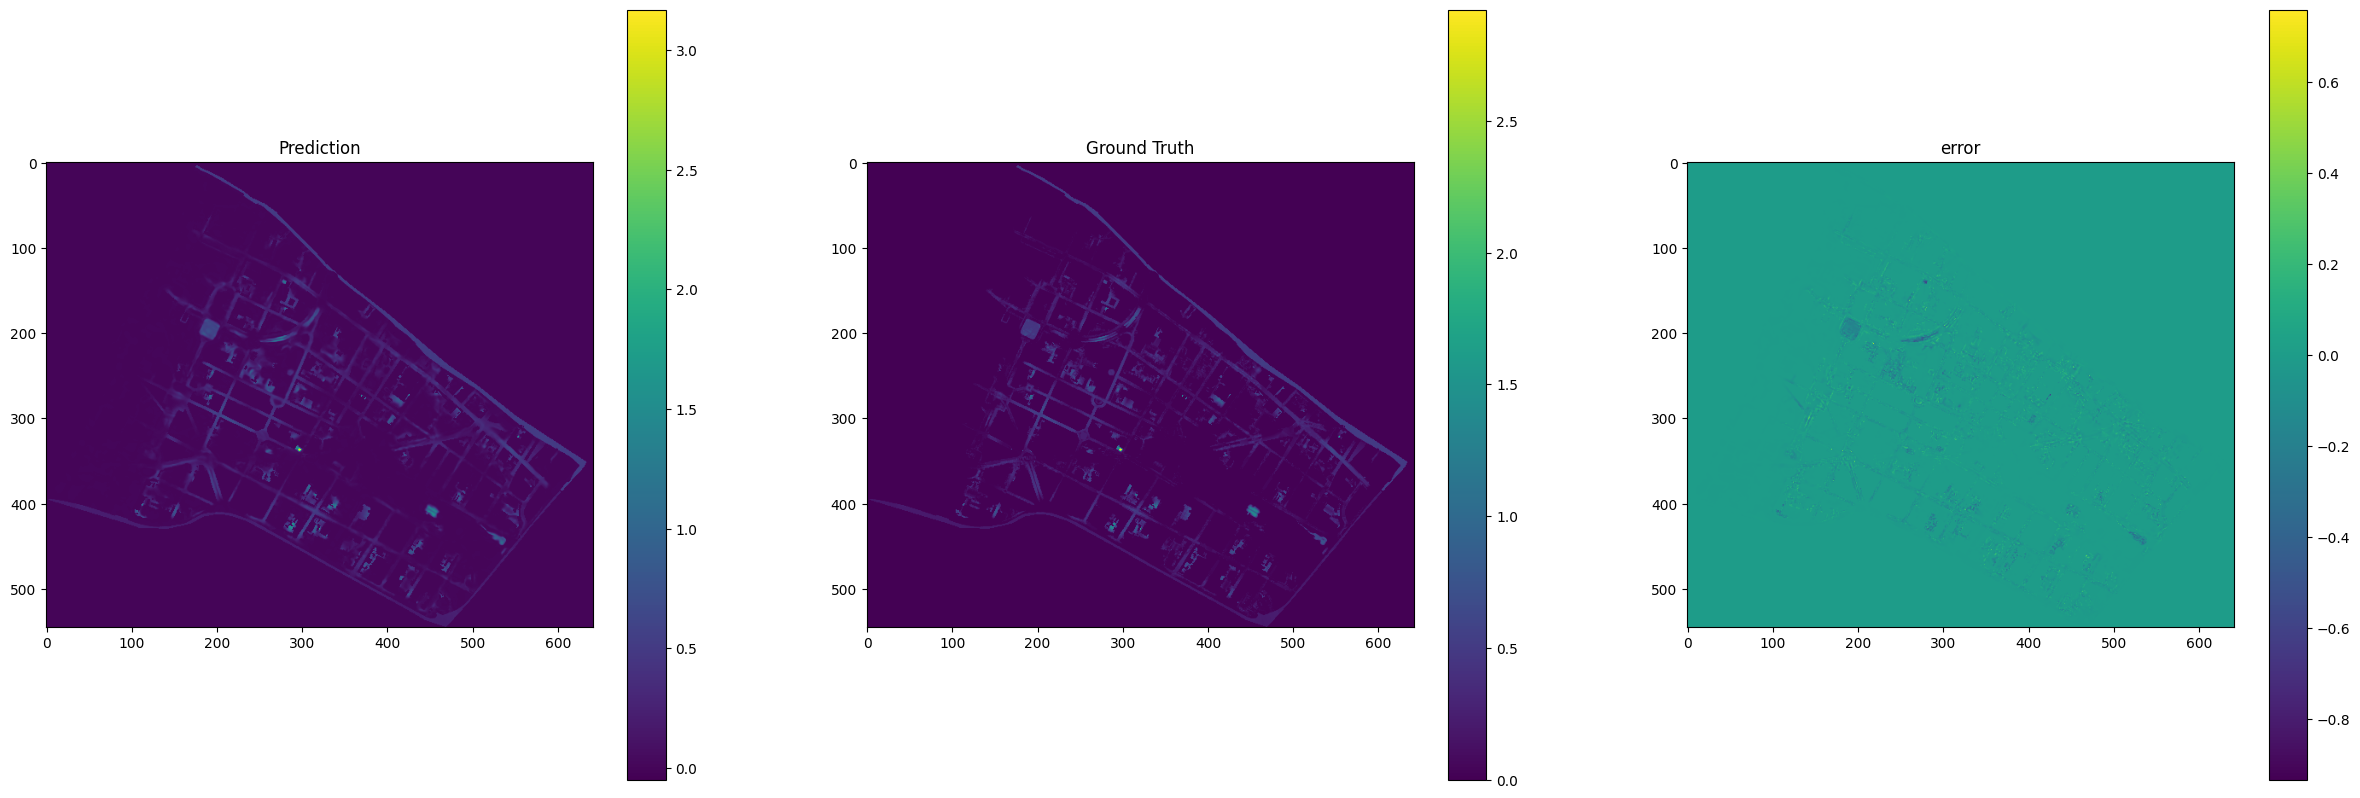

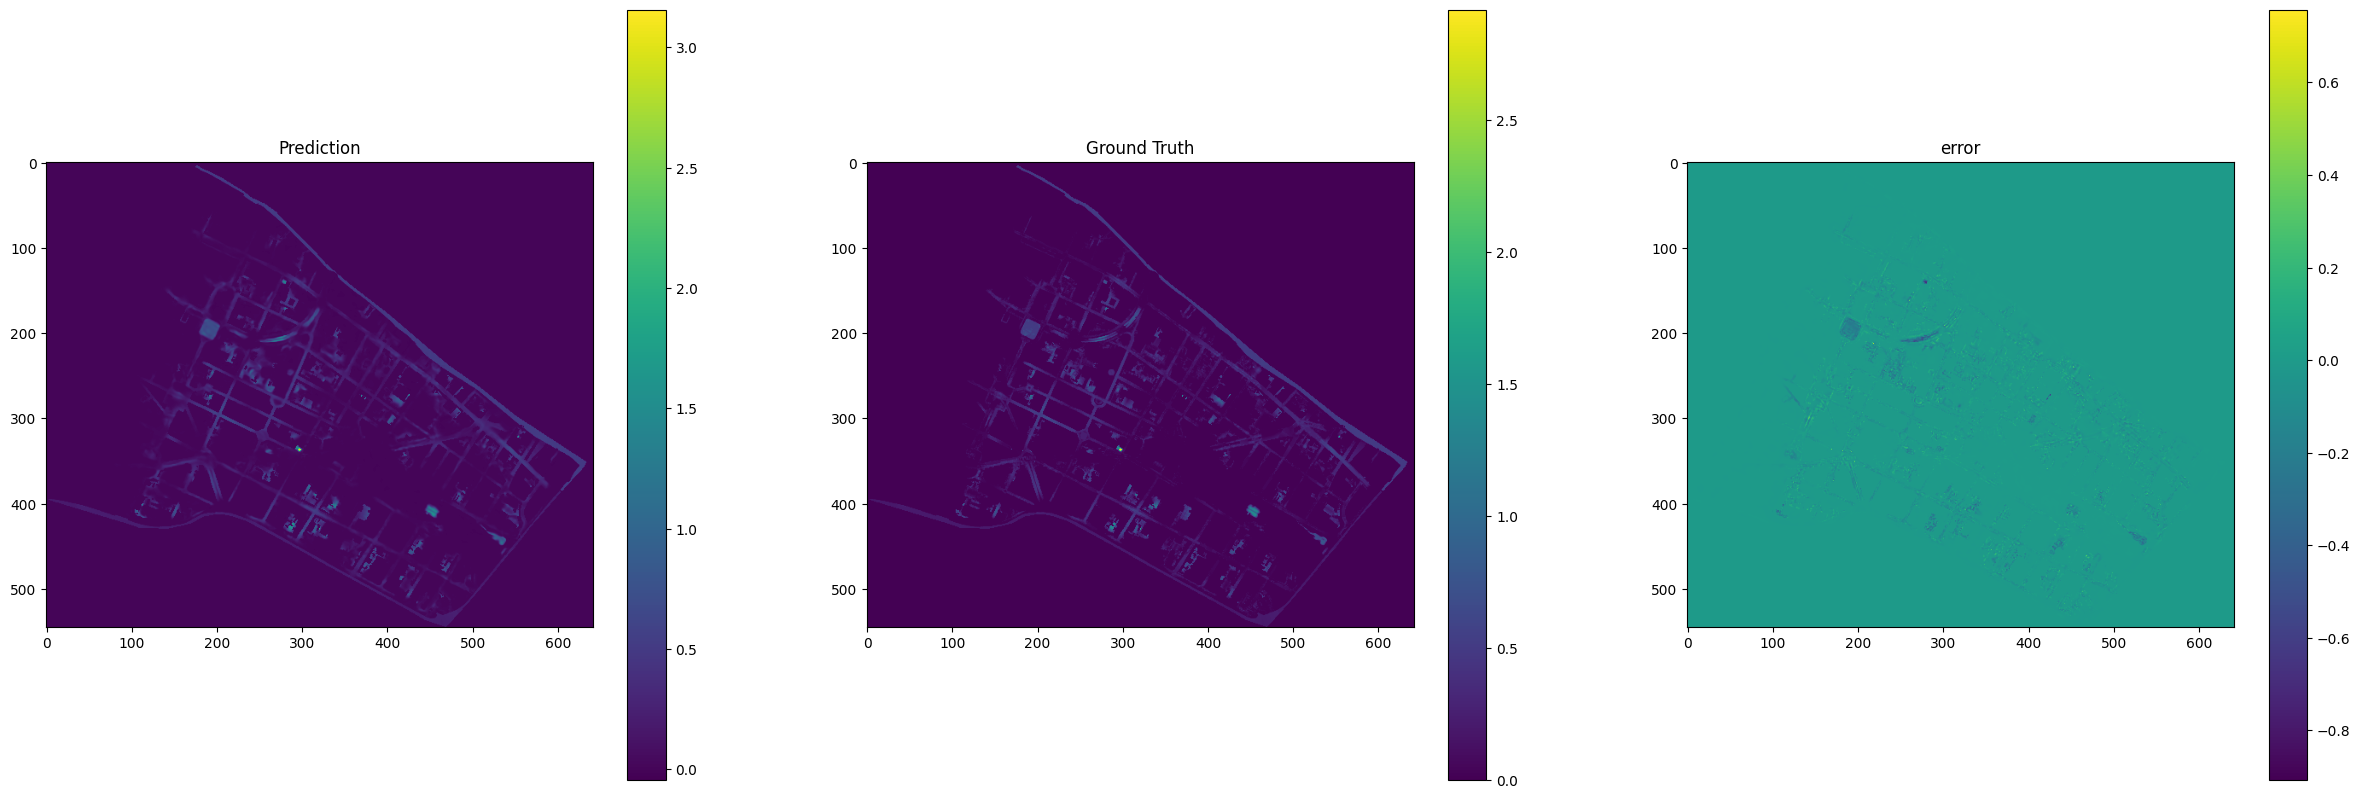

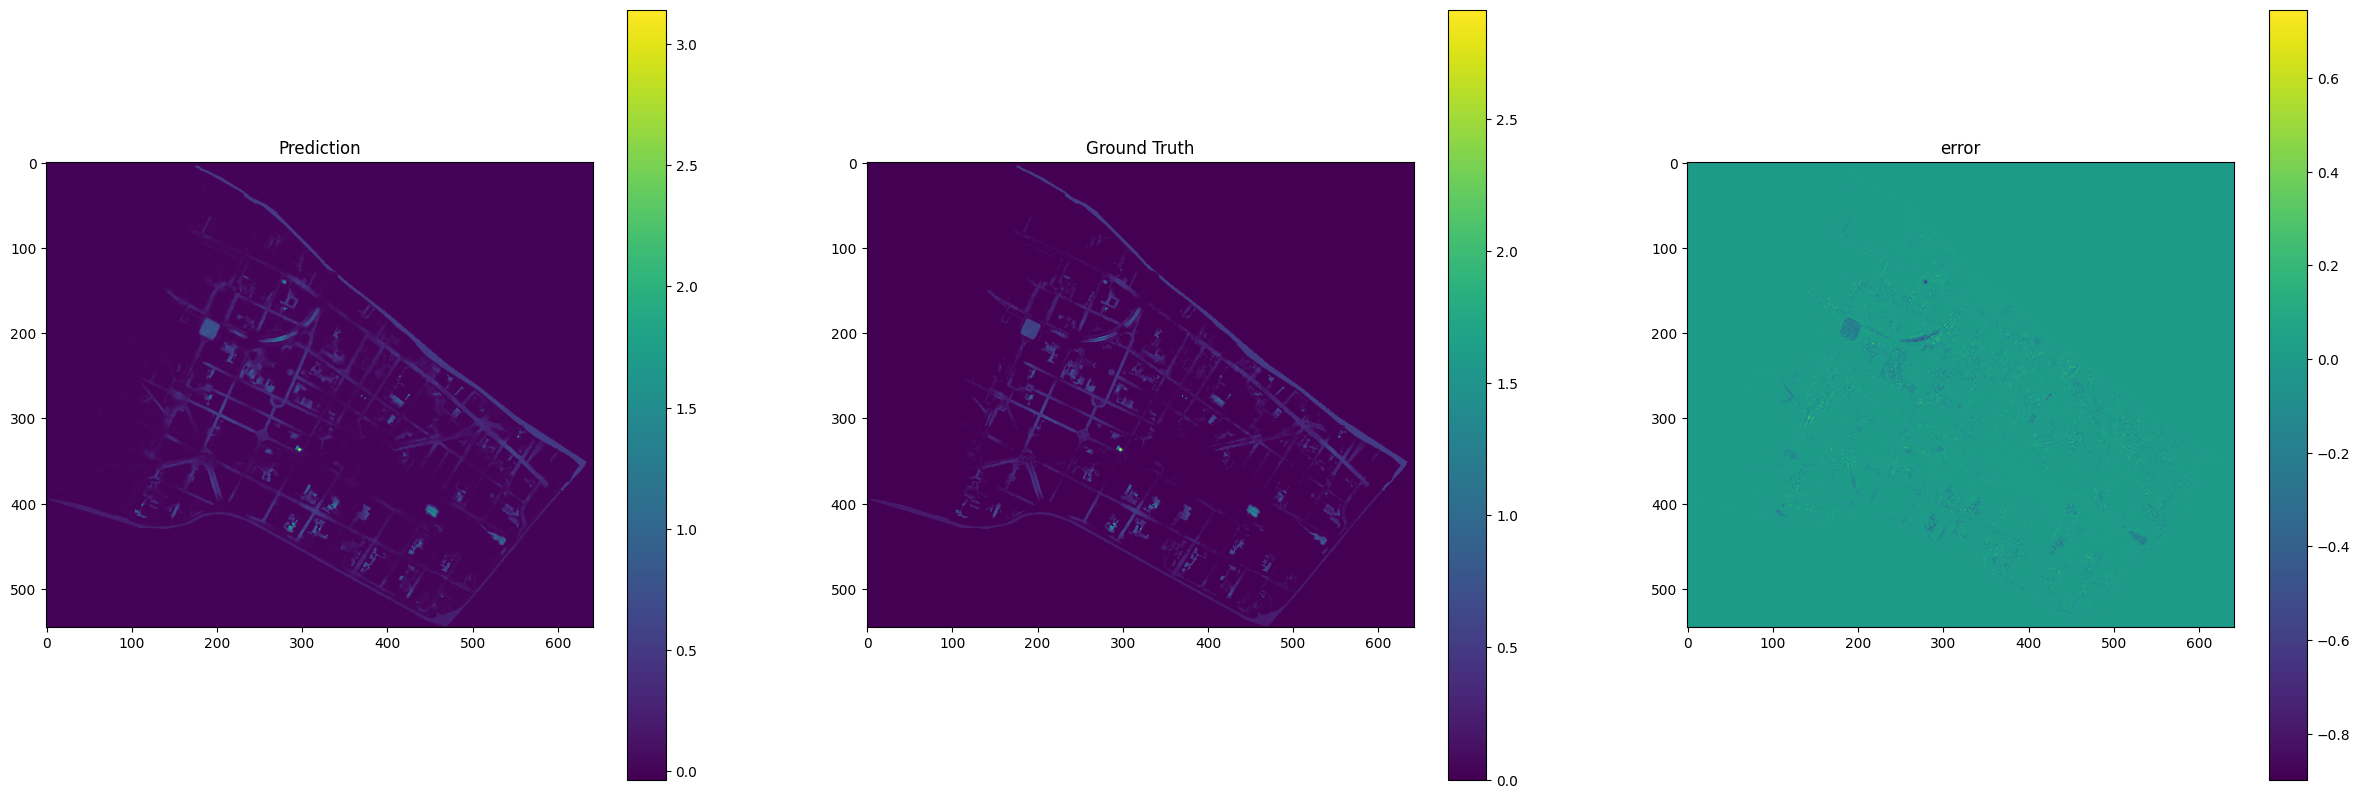

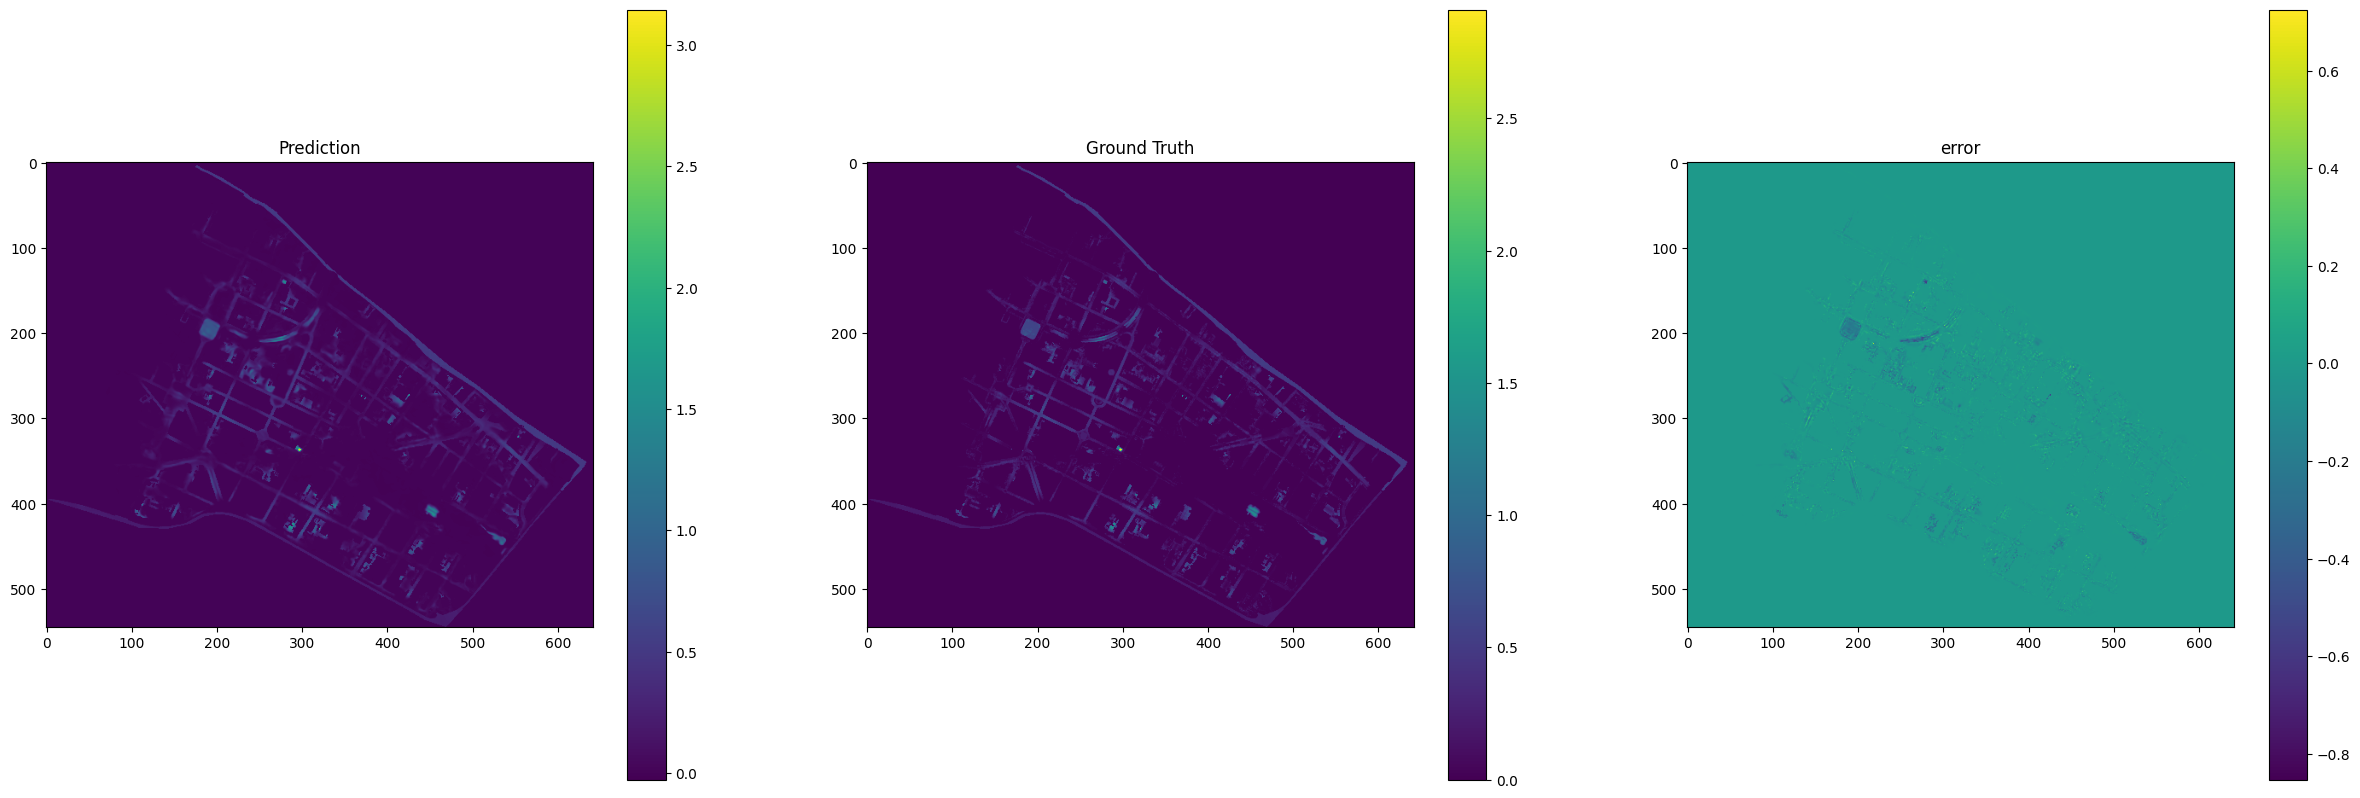

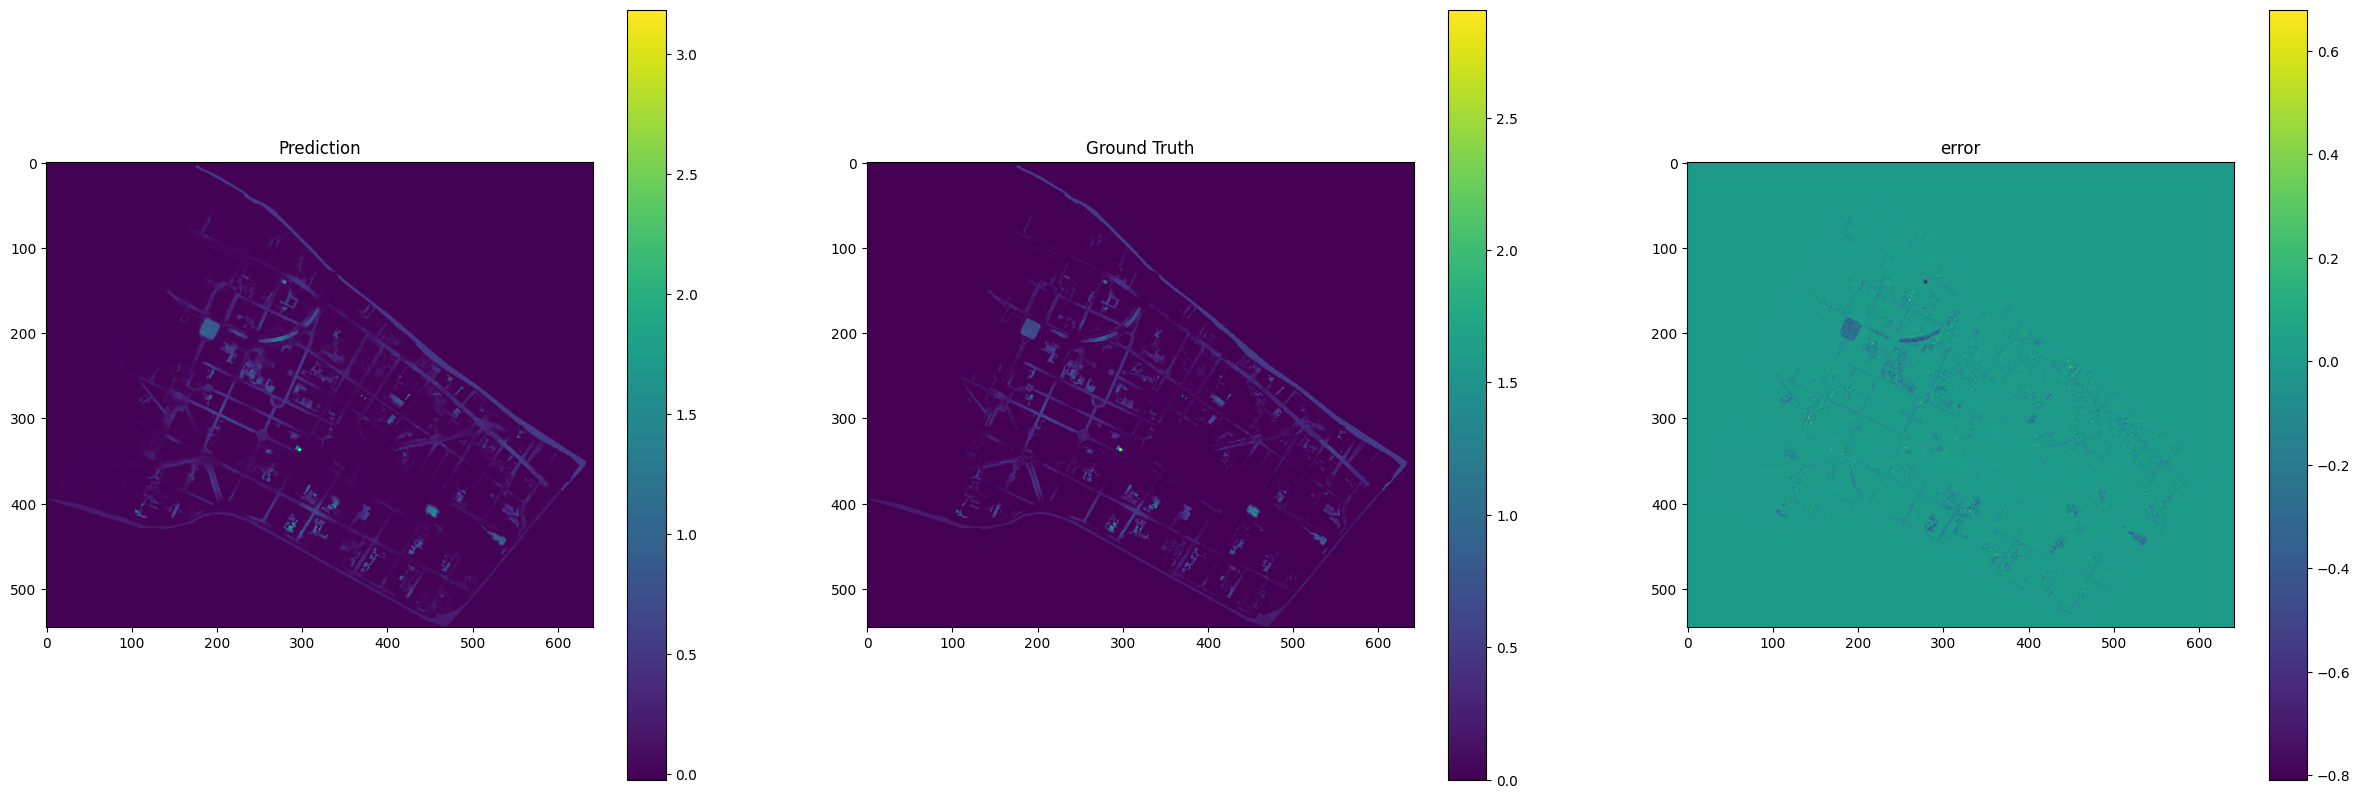

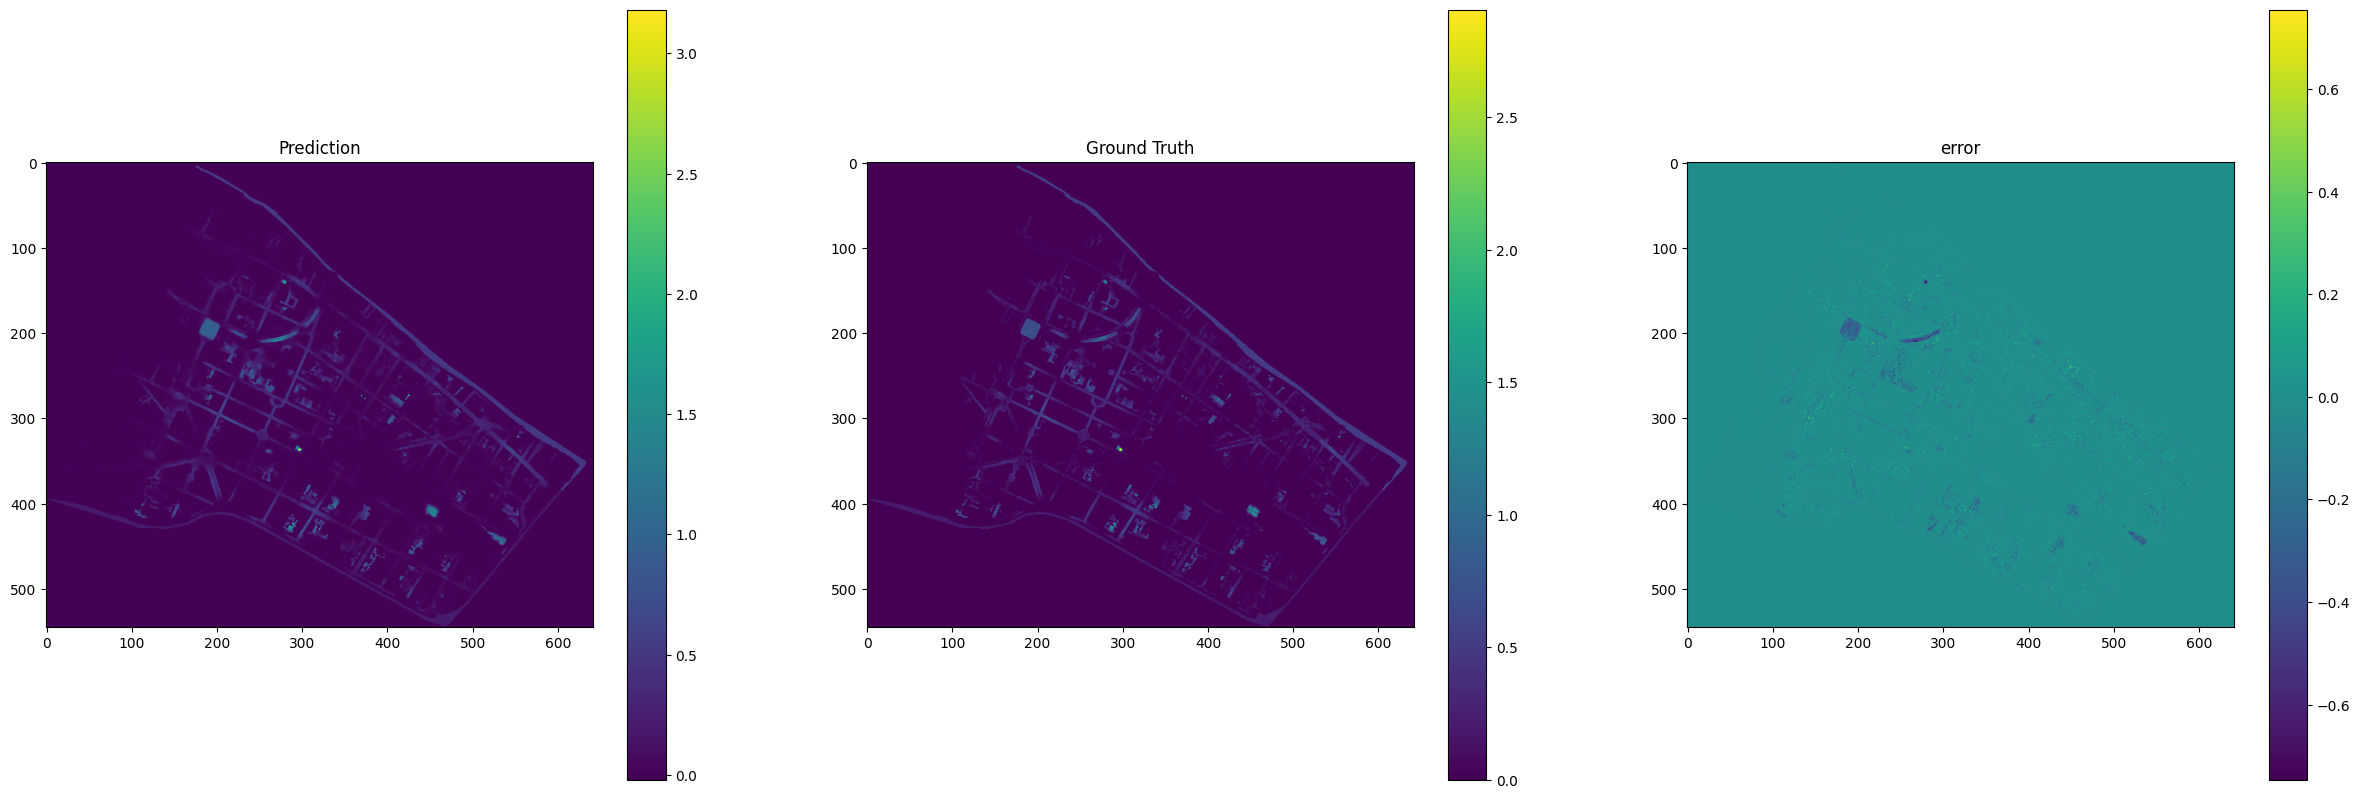

In [11]:
#visuliaze the 25 results with time series
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import imageio
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
for i in range(0,24):
    figure=plt.figure(figsize=(30, 10))
    sub1 = figure.add_subplot(131)

    plt.imshow(pred[0, :, :, i, 0].cpu().numpy())
    plt.title('Prediction')
    plt.colorbar()
    sub2 = figure.add_subplot(132)
    plt.imshow(yy[0, :, :, i, 0].cpu().numpy())
    plt.title('Ground Truth')
    plt.colorbar()
    sub3 = figure.add_subplot(133)

    plt.imshow((yy[0, :, :, i, 0] - pred[0, :, :, i, 0]).cpu().numpy())
    plt.title('error')
    plt.colorbar()

